# Temperature forecast for England using time series data: A Deep learning v/s a Machine learning approach

## Table of Contents <a class="anchor" id="0"></a>
* [Introduction](#1) 
* [Necessary Imports](#2)
* [Connecting to ArcGIS](#3)
* [Accessing & Visualizing the required datasets](#4) 
    * [England Boundary](#5)
    * [Weather Stations](#6)
    * [Historic Temperature Data](#7) 
* [Transforming to Timeseries Data](#8)
* [Model Building](#9)
    * [Feature engineering](#10)  
    * [LSTM](#11) 
    * [Temperature forecasted by LSTM model](#12) 
    * [Support Vector Machine(SVR)](#13) 
    * [Temperature forecasted by SVR model](#14)
* [Result Visualization](#15)
* [Conclusion](#16)
* [Summary of methods used](#18)
* [Data resources](#17)

## Introduction <a class="anchor" id="1"></a>

Weather forecasting has been a significant area for the application of advanced deep learning and machine learning methodologies over traditional methods to improve weather prediction. These new methods are appropriate for processing large chunks of data where massive quantity of historic weather datasets could be utilized which remains a challenge for meteorologist. Accordingly, in this sample study two autoregressive methods are attempted: one using a deep learning and another using a machine learning framework to predict temperature of England. 

Subsequently historic temperature data from various weather stations across England are collected and used to forecast daily temperature for the month of October, 2019. The past data consists of daily temperature measurements ranging from February,2005 till September, 2019 which are autoregressed to predict daily temperature for each of the identified stations for the said month. The forecasted temperature obtained for the stations are then spatially interpolated using ArcGIS spatial interpolation tools to produce a temperature prediction surface for the entire country.

## Necessary Imports <a class="anchor" id="2"></a>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from pandas import read_csv
import math
from datetime import datetime
from IPython.display import Image
from IPython.display import HTML

from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import sklearn.metrics as metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
import tensorflow.keras.backend as K

from arcgis.features import SpatialDataFrame
from arcgis.gis import GIS
from arcgis.features.analysis import interpolate_points

import arcgis
from arcgis.gis import GIS
from arcgis.raster.functions import apply, clip, remap, colormap
from arcgis.geocoding import geocode

## Connecting to ArcGIS <a class="anchor" id="3"></a>

In [2]:
gis = GIS("https://geosaurus.maps.arcgis.com", "arcgis_python", "P@ssword123", profile="your_online_profile")

## Accessing & Visualizing the required datasets<a class="anchor" id="4"></a>

The primary data used for this sample are as follows:

### Data 1— England Boundary <a class="anchor" id="5"></a>
First the boundary of England shapefile is accessed. This will be used to interpolate temperature within this particular area.

<Item title:"england1" type:Feature Layer Collection owner:api_data_owner>
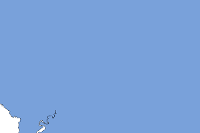

In [3]:
# Access England Boundary
england_border = gis.content.search('england1 owner:api_data_owner', 'feature layer')[0]
england_border

In [4]:
england_boundary_layer = england_border.layers[0]


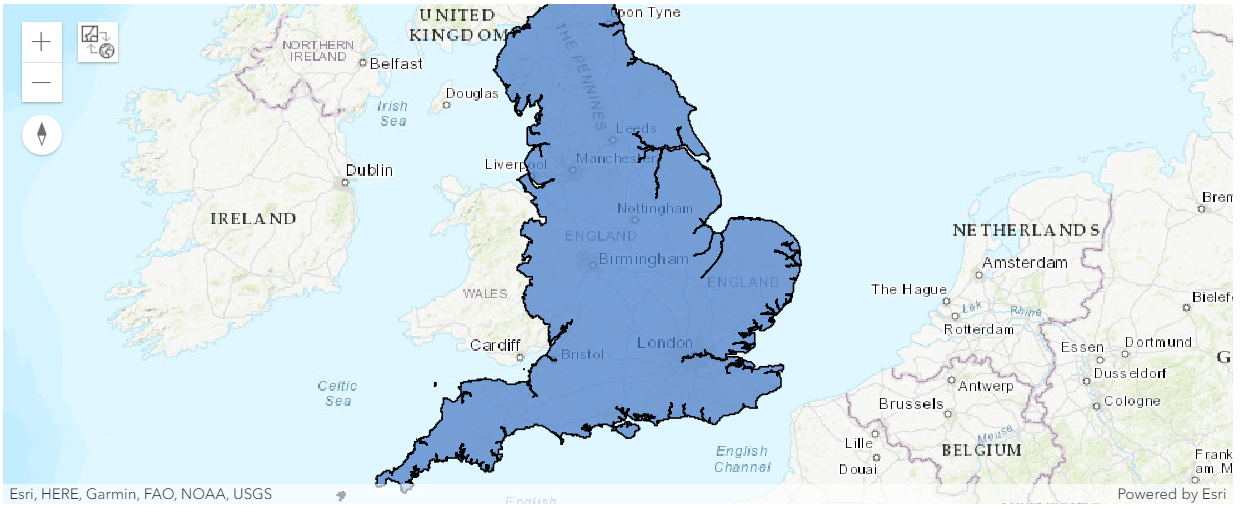

In [3]:
# Plot England boundary
m1 = gis.map('England', zoomlevel=6)
m1.add_layer(england_boundary_layer)
m1 

### Data 2 — Weather Stations  <a class="anchor" id="6"></a>
 
There are several weather stations in England which has been recording a variety of weather data from different time periods. Here 29 weather station are strategically selected  such that they are well distributed across England and can be used to forecast temperature which will cover the entire country. These include stations located at prominent English cities such as London, Birmingham, Cardiff, Exeter, Nottingham, Plymouth and others, and are shown in the map below. 

<Item title:"england_weather_stations1" type:Feature Layer Collection owner:api_data_owner>
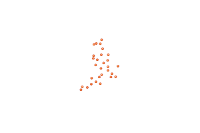

In [6]:
# Access England Weather Stations
england_weather_stations = gis.content.search('england_weather_stations1 owner:api_data_owner', 'feature layer')[0]
england_weather_stations

In [7]:
england_weather_stations_layer = england_weather_stations.layers[0]

In [8]:
england_weather_stations_layer.properties.extent

{
  "xmin": -584427.3266646799,
  "ymin": 6460720.232993091,
  "xmax": 142798.41639980205,
  "ymax": 7443868.808735475,
  "spatialReference": {
    "wkid": 102100,
    "latestWkid": 3857
  }
}


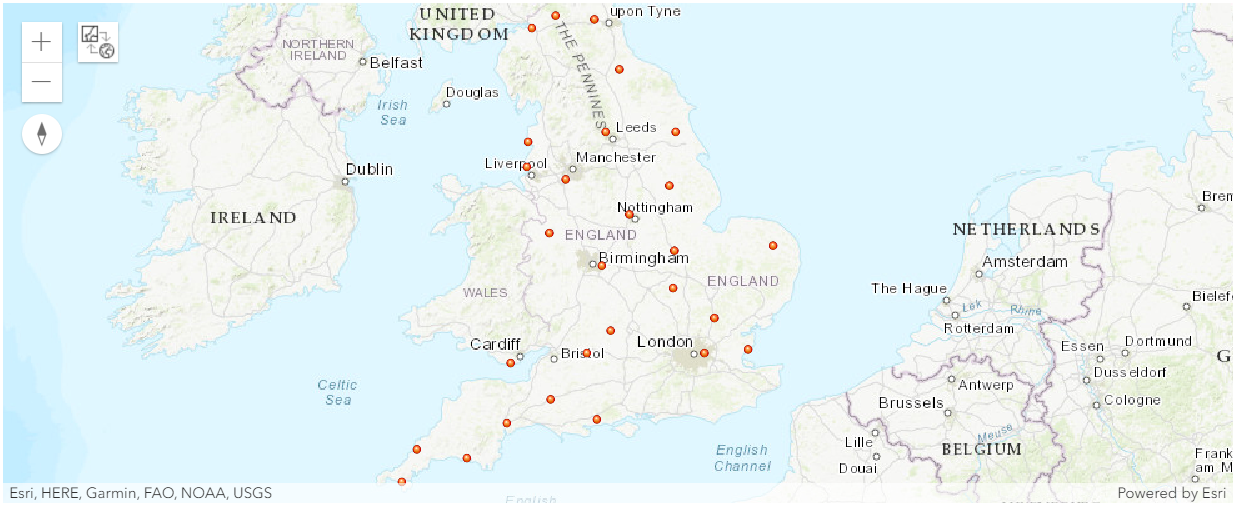

In [4]:
# England weather stations
m2 = gis.map('England', zoomlevel=6)
m2.add_layer(england_weather_stations_layer)
m2

In [10]:
# Access spatial dataframe
england_weather_stations_layer_sdf = pd.DataFrame.spatial.from_layer(england_weather_stations_layer)
england_weather_stations_layer_sdf.head()

C:\Users\sup10432\.conda\envs\arcgis171\lib\site-packages\IPython\lib\pretty.py:402: FutureWarning: 'ExtensionArray._formatting_values' is deprecated. Specify 'ExtensionArray._formatter' instead.
  return _repr_pprint(obj, self, cycle)
C:\Users\sup10432\.conda\envs\arcgis171\lib\site-packages\pandas\io\formats\html.py:606: FutureWarning: 'ExtensionArray._formatting_values' is deprecated. Specify 'ExtensionArray._formatter' instead.
  super().render()


FID             Station          Y         X  \
0    1           Albemarle  55.016667 -1.866667   
1    2             Begwary  52.216667 -0.483333   
2    3  Birmingham_airport  52.450000 -1.733333   
3    4   Blackpool_airport  53.766667 -3.033333   
4    5     Boulmer_airport  55.420300 -1.599700   

                                               SHAPE  
0  {"x": -207796.38285121127, "y": 7365101.445978...  
1  {"x": -53804.420512971476, "y": 6839396.777444...  
2  {"x": -192953.78400456344, "y": 6881903.804921...  
3  {"x": -337669.1220358203, "y": 7126089.0211904...  
4  {"x": -178077.78942199165, "y": 7443868.808735...

### Data 3 —  Historic Temperature  <a class="anchor" id="7"></a>
Daily Mean temperature in degree Celsius ranging from February, 2005 till September,2019 are accessed from the above mentioned weather stations from this [website](https://rp5.ru/Weather_in_the_world) which will be the main dataset for the study. One issue with timeseries datasets that needed to be addressed was that of missing data. Thus weather stations with the least amount of missing data were selected for the study and the remaining missing data were temporally interpolated to produce the final dataset. It is as follows:

In [11]:
# Access historic temperature data of England
table = gis.content.search('all_station_date owner:api_data_owner')[0]

In [12]:
x=table.tables[0]

In [13]:
# Visualize as pandas dataframe
t=x.query().sdf

In [14]:
t.tail()

Date Albemarle Begwary Birmingham_airport Blackpool_airport  \
5350  26-09-2019     13.79   16.15              15.62             15.24   
5351  27-09-2019      10.9   13.72              13.28             13.72   
5352  28-09-2019     11.26   14.11               13.9             14.12   
5353  29-09-2019     10.68   15.25              14.79             12.68   
5354  30-09-2019      10.1   12.91              12.73              13.6   

      Boulmer_airport Bournemouth_airport  BrizeNorton_airport  \
5350              NaN               16.99                15.95   
5351              NaN               15.08                14.05   
5352              NaN               15.95                14.31   
5353              NaN               15.88                15.38   
5354              NaN               14.22                13.14   

     Cardiff_airport Carlisle  ... Nottingham Plymouth_weatherstation  \
5350           15.77     14.1  ...      14.46                   15.96   
5351           14.88    12.25  ...      12.79                   14.60   
5352           15.33    12.37  ...      13.46                   15.03   
5353           14.98     11.8  ...      13.66                   15.19   
5354           14.27    11.08  ...      12.11                   14.78   

     Rostherne Scampton_airport Shawbury_airport Southend_on_Sea_AWS  \
5350      14.9            15.21            14.65               17.16   
5351     12.77            13.05            13.37               15.76   
5352     13.67            13.36            13.91               15.68   
5353     13.19            13.49            14.14               16.18   
5354     12.12            12.08            12.02               14.31   

     Stansted_airport Wittering_airport  Yeovilton_airport ObjectId  
5350            16.27             15.85              16.64     5351  
5351            14.21             13.22              14.95     5352  
5352            14.19             14.10              15.37     5353  
5353            15.31             14.74              15.65     5354  
5354             13.5             12.56              13.70     5355  

[5 rows x 31 columns]

In [15]:
t.shape

(5355, 31)

In [16]:
england_temp = t[t.columns[0:30]]

In [17]:
england_temp.tail()

Date Albemarle Begwary Birmingham_airport Blackpool_airport  \
5350  26-09-2019     13.79   16.15              15.62             15.24   
5351  27-09-2019      10.9   13.72              13.28             13.72   
5352  28-09-2019     11.26   14.11               13.9             14.12   
5353  29-09-2019     10.68   15.25              14.79             12.68   
5354  30-09-2019      10.1   12.91              12.73              13.6   

      Boulmer_airport Bournemouth_airport  BrizeNorton_airport  \
5350              NaN               16.99                15.95   
5351              NaN               15.08                14.05   
5352              NaN               15.95                14.31   
5353              NaN               15.88                15.38   
5354              NaN               14.22                13.14   

     Cardiff_airport Carlisle  ... Norwich_airport Nottingham  \
5350           15.77     14.1  ...            16.6      14.46   
5351           14.88    12.25  ...           13.89      12.79   
5352           15.33    12.37  ...           14.42      13.46   
5353           14.98     11.8  ...           15.46      13.66   
5354           14.27    11.08  ...           13.87      12.11   

     Plymouth_weatherstation Rostherne Scampton_airport Shawbury_airport  \
5350                   15.96      14.9            15.21            14.65   
5351                   14.60     12.77            13.05            13.37   
5352                   15.03     13.67            13.36            13.91   
5353                   15.19     13.19            13.49            14.14   
5354                   14.78     12.12            12.08            12.02   

     Southend_on_Sea_AWS Stansted_airport  Wittering_airport Yeovilton_airport  
5350               17.16            16.27              15.85             16.64  
5351               15.76            14.21              13.22             14.95  
5352               15.68            14.19              14.10             15.37  
5353               16.18            15.31              14.74             15.65  
5354               14.31             13.5              12.56             13.70  

[5 rows x 30 columns]

## Transforming to Timeseries data <a class="anchor" id="8"></a>

The historic temperature data of England is now transformed into a timeseries data format where the index represents the date of the observed temperature. 

In [18]:
# Change to datetime format
england_temp_new = england_temp.copy() 
england_temp_new[england_temp_new.columns[0]] = pd.to_datetime(england_temp_new[england_temp_new.columns[0]], format='%d-%m-%Y')
england_temp_new = england_temp_new.set_index(england_temp_new.columns[0])
england_temp_new = england_temp_new.sort_index()
all_station_temp = england_temp_new.astype('float')
all_station_temp.tail()

Albemarle  Begwary  Birmingham_airport  Blackpool_airport  \
Date                                                                    
2019-09-26      13.79    16.15               15.62              15.24   
2019-09-27      10.90    13.72               13.28              13.72   
2019-09-28      11.26    14.11               13.90              14.12   
2019-09-29      10.68    15.25               14.79              12.68   
2019-09-30      10.10    12.91               12.73              13.60   

            Boulmer_airport  Bournemouth_airport  BrizeNorton_airport  \
Date                                                                    
2019-09-26              NaN                16.99                15.95   
2019-09-27              NaN                15.08                14.05   
2019-09-28              NaN                15.95                14.31   
2019-09-29              NaN                15.88                15.38   
2019-09-30              NaN                14.22                13.14   

            Cardiff_airport  Carlisle  Crosby  ...  Norwich_airport  \
Date                                           ...                    
2019-09-26            15.77     14.10   15.45  ...            16.60   
2019-09-27            14.88     12.25   13.96  ...            13.89   
2019-09-28            15.33     12.37   14.40  ...            14.42   
2019-09-29            14.98     11.80   13.29  ...            15.46   
2019-09-30            14.27     11.08   13.82  ...            13.87   

            Nottingham  Plymouth_weatherstation  Rostherne  Scampton_airport  \
Date                                                                           
2019-09-26       14.46                    15.96      14.90             15.21   
2019-09-27       12.79                    14.60      12.77             13.05   
2019-09-28       13.46                    15.03      13.67             13.36   
2019-09-29       13.66                    15.19      13.19             13.49   
2019-09-30       12.11                    14.78      12.12             12.08   

            Shawbury_airport  Southend_on_Sea_AWS  Stansted_airport  \
Date                                                                  
2019-09-26             14.65                17.16             16.27   
2019-09-27             13.37                15.76             14.21   
2019-09-28             13.91                15.68             14.19   
2019-09-29             14.14                16.18             15.31   
2019-09-30             12.02                14.31             13.50   

            Wittering_airport  Yeovilton_airport  
Date                                              
2019-09-26              15.85              16.64  
2019-09-27              13.22              14.95  
2019-09-28              14.10              15.37  
2019-09-29              14.74              15.65  
2019-09-30              12.56              13.70  

[5 rows x 29 columns]

## Model Building <a class="anchor" id="9"></a>
Now once the dataset is transformed into a timeseries dataset it is ready to be used for modeling. In this sample two types of methodology are used for modeling: 

1) LSTM - First a deep learning framework of LSTM is used which is appropriate for handling time series data. 

2) Support Vector Machine  - In the second option the machine learning algorithm of Support Vector Regression(SVR) is used to compare the performance between the two methods in terms of accuracy and computation time.

## Feature engineering <a class="anchor" id="10"></a>

Finally one more transformation of feature engineering is required, which is to create new features using lagged values of the time series data itself. Here the number of lag terms could be specified and the function would create a new feature set using the lagged terms, having lag number of features.  

In [19]:
# Creating features using lagged data
def timeseries_feature_builder(df, lag):
    df_copy = df.copy()
    for i in range(1,lag):
        df_copy['lag'+str(i)] = df.shift(i) 
    return df_copy
    df_copy = df.copy()

## LSTM <a class="anchor" id="11"></a>

Now a function is created which encapsulates the steps for processing and predicting from the timeseries data. This consists of first fitting a deep learning model of Long short-term memory(LSTM), followed by forecasting for a given future time period using the fitted model.     

In [20]:
def england_temp_lstm(all_station_temp, lag, days):
    
    # creating future forecast dates
    v = pd.date_range(start='2019-09-30', periods=days+1, freq='D', closed='right')
    seven_day_forecast = pd.DataFrame(index=v)
    
    for i in range(len(all_station_temp.columns)):
        
        # Data preparation 
        station_value = all_station_temp[[all_station_temp.columns[i]]].dropna()
        station_name = all_station_temp.columns[i]

        
        nrow = len(station_value)
        print(station_name+' total row: ',nrow)
        split_row = int((nrow)*.90)
        print('split_row: ',split_row)
    
        train_tract1 = station_value.iloc[:split_row]
        test_tract1 = station_value.iloc[split_row:]

        
        scaler = MinMaxScaler()
        train_tract1_scaled = scaler.fit_transform(train_tract1)
        test_tract1_scaled = scaler.fit_transform(test_tract1)

        train_tract1_scaled_df = pd.DataFrame(train_tract1_scaled, index = train_tract1.index, columns=[train_tract1.columns[0]])
        test_tract1_scaled_df = pd.DataFrame(test_tract1_scaled, index = test_tract1.index, columns=[test_tract1.columns[0]])

         
        train_tract1 = timeseries_feature_builder(train_tract1_scaled_df, lag+1)
        test_tract1 = timeseries_feature_builder(test_tract1_scaled_df, lag+1)

        X_train_tract1 = train_tract1.dropna().drop(train_tract1.columns[0], axis=1)
        y_train_tract1 = train_tract1.dropna()[train_tract1.columns[0]]

        X_test_tract1 = test_tract1.dropna().drop(test_tract1.columns[0], axis=1)
        y_test_tract1 = test_tract1.dropna()[test_tract1.columns[0]]

       
        X_train_tract1_array = X_train_tract1.values
        y_train_tract1_array = y_train_tract1.values


        X_test_tract1_array = X_test_tract1.values
        y_test_tract1_array = y_test_tract1.values

        
        # Fitting LSTM 
        K.clear_session()

        trainX = np.reshape(X_train_tract1_array, (X_train_tract1_array.shape[0],1,X_train_tract1_array.shape[1]))
        testX = np.reshape(X_test_tract1_array, (X_test_tract1_array.shape[0],1,X_test_tract1_array.shape[1]))


        model = Sequential()
        model.add(LSTM(30,return_sequences=True, input_shape=(trainX.shape[1],trainX.shape[2]),kernel_initializer='lecun_uniform')) 
        model.add(LSTM(30, return_sequences=True))
        model.add(LSTM(30, return_sequences=True))
        model.add(LSTM(30, return_sequences=True))
        model.add(LSTM(30))
        model.add(Dropout(0.4))
        model.add(Dense(1))        
        model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')

        history = model.fit(trainX, y_train_tract1_array, batch_size=64, epochs=100, validation_data=(testX, y_test_tract1_array), verbose=1)


        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)

        rSquare_test = r2_score(y_test_tract1_array, testPredict)
        print('Test R-squared is: %f'%rSquare_test)


        
        trainPredict_inverse = scaler.inverse_transform(trainPredict)
        trainY = scaler.inverse_transform([y_train_tract1_array])
        testPredict = scaler.inverse_transform(testPredict)
        testY = scaler.inverse_transform([y_test_tract1_array])
        
             
        trainRMSE = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
        print('Train RMSE: %.2f RMSE' % (trainRMSE))
        testRMSE = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
        print('Test RMSE: %.2f RMSE' % (testRMSE))      
        
        
        
        new_test_tract1 = station_value.iloc[split_row:]       
        test_tract1_pred = new_test_tract1.iloc[lag:].copy()
        test_tract1_pred['Forecast'] = testPredict     
        
        
        # multi step future forecast for 30 days 
        seven_days = []
        new0 = testX[-1]

        
        last = test_tract1.iloc[-1]
        new_predict = last[0]

        
        new_array = np.insert(new0, 0, new_predict)

        
        new_array = np.delete(new_array, -1)
        new_array_reshape = np.reshape(new_array, (-1,1,lag))

        
        new_predict = model.predict(new_array_reshape)
        temp_predict = scaler.inverse_transform(new_predict) 
        seven_days.append(temp_predict[0][0].round(2))


        for i in range(1,days):
            # inserting predicted value to begining of the array
            new_array = np.insert(new_array, 0, new_predict)

            # deleting the last item 
            new_array = np.delete(new_array, -1)
            new_array_reshape = np.reshape(new_array, (-1,1,lag))
    
            # predict again using the predicted value
            new_predict = model.predict(new_array_reshape)
            temp_predict = scaler.inverse_transform(new_predict) 
            seven_days.append(temp_predict[0][0].round(2))         
            
        
        seven_day_forecast[station_name] = np.array(seven_days)
        
        plt.figure(figsize=(20,5))
        plt.plot(test_tract1_pred)        
        plt.plot(seven_day_forecast[station_name], color='red', label='forecast')         
        plt.ylabel('Temperature(°C)')
        plt.legend(loc='upper right')
        plt.title(station_name + '- October 2019 Temperature Forecast')
        plt.show()    
        
        
    return(seven_day_forecast)

Now the above function is called on the weather station dataset consisting of past temperature data from the selcted weather stations. It is given three input: the data table, lag in number of days to be used and the number of days for which the temperature is to be predicted.

Albemarle total row:  3648
split_row:  3283
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 3163 samples, validate on 245 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
3163/3163 [==============================] - ETA: 2:50 - loss: 0.345 - ETA: 55s - loss: 0.334 - ETA: 22s - loss: 0.32 - ETA: 8s - loss: 0.3103 - ETA: 5s - loss: 0.302 - ETA: 3s - loss: 0.285 - ETA: 1s - loss: 0.259 - ETA: 0s - loss: 0.220 - 4s 1ms/sample - loss: 0.2013 - val_loss: 0.0311
Epoch 2/100
3163/3163 [==============================] - ETA: 0s - loss: 0.045 - ETA: 0s - loss: 0.038 - ETA: 0s - loss: 0.036 - ETA: 0s - loss: 0.037 - ETA: 0s - loss: 0.037 - ETA: 0s - loss: 0.035 - ETA: 0s - loss: 0.035 - ETA: 0s - loss: 0.034 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.033 - 1s 188us/sample - loss: 0.0332 - val_loss: 0.0197
Epoch 3/100
3163/3163 [==========================

C:\Users\sup10432\.conda\envs\arcgis171\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


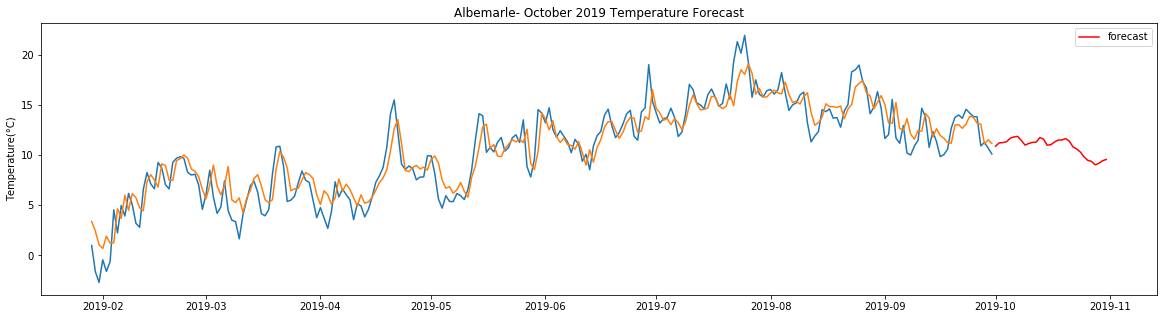

Begwary total row:  3648
split_row:  3283
Train on 3163 samples, validate on 245 samples
Epoch 1/100
3163/3163 [==============================] - ETA: 2:51 - loss: 0.266 - ETA: 14s - loss: 0.279 - ETA: 6s - loss: 0.2604 - ETA: 3s - loss: 0.243 - ETA: 1s - loss: 0.215 - ETA: 0s - loss: 0.183 - 4s 1ms/sample - loss: 0.1704 - val_loss: 0.0326
Epoch 2/100
3163/3163 [==============================] - ETA: 0s - loss: 0.039 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.030 - 0s 105us/sample - loss: 0.0296 - val_loss: 0.0333
Epoch 3/100
3163/3163 [==============================] - ETA: 0s - loss: 0.026 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.023 - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.019 - ETA: 0s - loss: 0.017 - 0s 108us/sample - loss: 0.0170 - val_loss: 0.0117
Epoch 4/100
3163/3163 [==============================] - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.012 - ETA

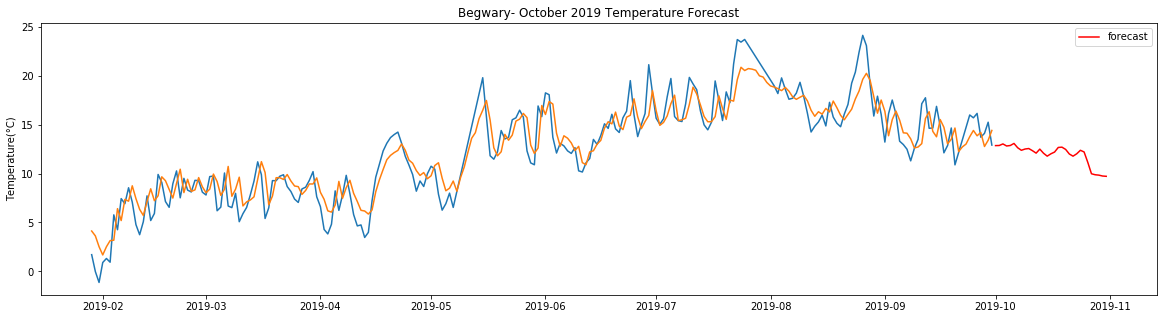

Birmingham_airport total row:  2556
split_row:  2300
Train on 2180 samples, validate on 136 samples
Epoch 1/100
2180/2180 [==============================] - ETA: 1:58 - loss: 0.307 - ETA: 10s - loss: 0.283 - ETA: 4s - loss: 0.2742 - ETA: 1s - loss: 0.257 - ETA: 0s - loss: 0.233 - 4s 2ms/sample - loss: 0.2226 - val_loss: 0.1457
Epoch 2/100
2180/2180 [==============================] - ETA: 0s - loss: 0.080 - ETA: 0s - loss: 0.054 - ETA: 0s - loss: 0.048 - ETA: 0s - loss: 0.048 - ETA: 0s - loss: 0.044 - ETA: 0s - loss: 0.041 - 0s 155us/sample - loss: 0.0408 - val_loss: 0.0367
Epoch 3/100
2180/2180 [==============================] - ETA: 0s - loss: 0.038 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.030 - ETA: 0s - loss: 0.029 - 0s 113us/sample - loss: 0.0297 - val_loss: 0.0138
Epoch 4/100
2180/2180 [==============================] - ETA: 0s - loss: 0.021 - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.016 - 0s 109us/sample 

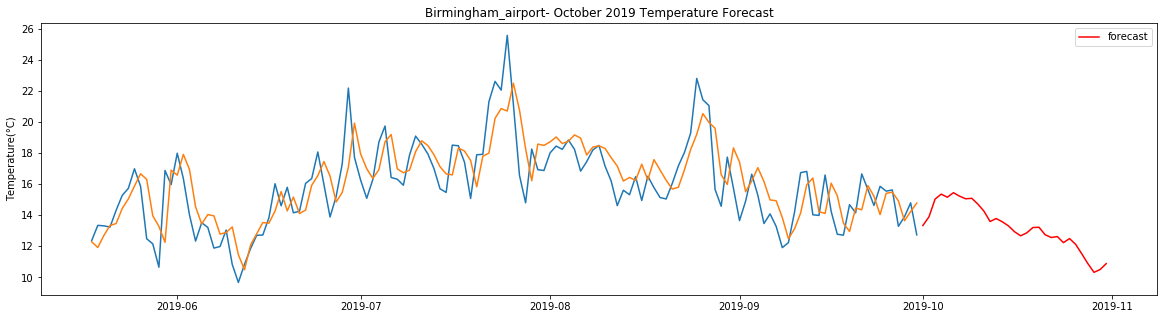

Blackpool_airport total row:  3501
split_row:  3150
Train on 3030 samples, validate on 231 samples
Epoch 1/100
3030/3030 [==============================] - ETA: 2:47 - loss: 0.400 - ETA: 15s - loss: 0.353 - ETA: 8s - loss: 0.3356 - ETA: 3s - loss: 0.316 - ETA: 1s - loss: 0.287 - ETA: 0s - loss: 0.248 - 5s 1ms/sample - loss: 0.2243 - val_loss: 0.0250
Epoch 2/100
3030/3030 [==============================] - ETA: 0s - loss: 0.044 - ETA: 0s - loss: 0.035 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.030 - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.029 - 0s 104us/sample - loss: 0.0290 - val_loss: 0.0216
Epoch 3/100
3030/3030 [==============================] - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.025 - ETA: 0s - loss: 0.025 - ETA: 0s - loss: 0.025 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.022 - 0s 103us/sample - loss: 0.0221 - val_loss: 0.0084
Epoch 4/100
3030/3030 [==============================] - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0

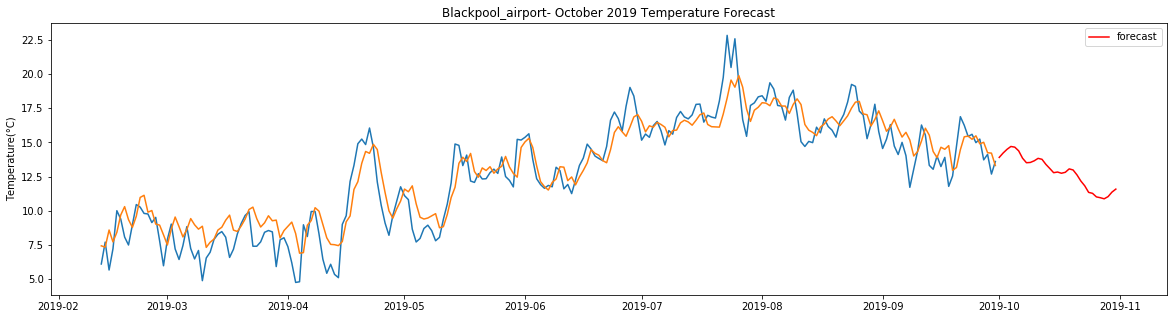

Boulmer_airport total row:  5302
split_row:  4771
Train on 4651 samples, validate on 411 samples
Epoch 1/100
4651/4651 [==============================] - ETA: 4:29 - loss: 0.310 - ETA: 26s - loss: 0.315 - ETA: 13s - loss: 0.29 - ETA: 11s - loss: 0.28 - ETA: 8s - loss: 0.2723 - ETA: 5s - loss: 0.245 - ETA: 3s - loss: 0.213 - ETA: 1s - loss: 0.182 - ETA: 1s - loss: 0.162 - ETA: 0s - loss: 0.145 - 5s 1ms/sample - loss: 0.1357 - val_loss: 0.0304
Epoch 2/100
4651/4651 [==============================] - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.036 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.030 - ETA: 0s - loss: 0.028 - ETA: 0s - loss: 0.026 - ETA: 0s - loss: 0.025 - 0s 107us/sample - loss: 0.0243 - val_loss: 0.0088
Epoch 3/100
4651/4651 [==============================] - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.015 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0

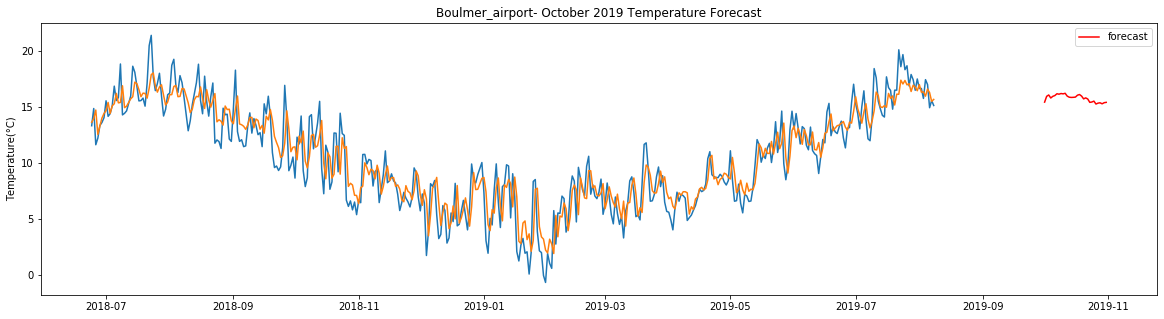

Bournemouth_airport total row:  3648
split_row:  3283
Train on 3163 samples, validate on 245 samples
Epoch 1/100
3163/3163 [==============================] - ETA: 3:08 - loss: 0.288 - ETA: 17s - loss: 0.283 - ETA: 7s - loss: 0.2722 - ETA: 3s - loss: 0.255 - ETA: 2s - loss: 0.230 - ETA: 0s - loss: 0.193 - 5s 2ms/sample - loss: 0.1702 - val_loss: 0.0269
Epoch 2/100
3163/3163 [==============================] - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.030 - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.028 - ETA: 0s - loss: 0.028 - 0s 107us/sample - loss: 0.0283 - val_loss: 0.0243
Epoch 3/100
3163/3163 [==============================] - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.021 - ETA: 0s - loss: 0.019 - ETA: 0s - loss: 0.018 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.015 - 0s 109us/sample - loss: 0.0158 - val_loss: 0.0086
Epoch 4/100
3163/3163 [==============================] - ETA: 0s - loss: 0.012 - ETA: 1s - loss:

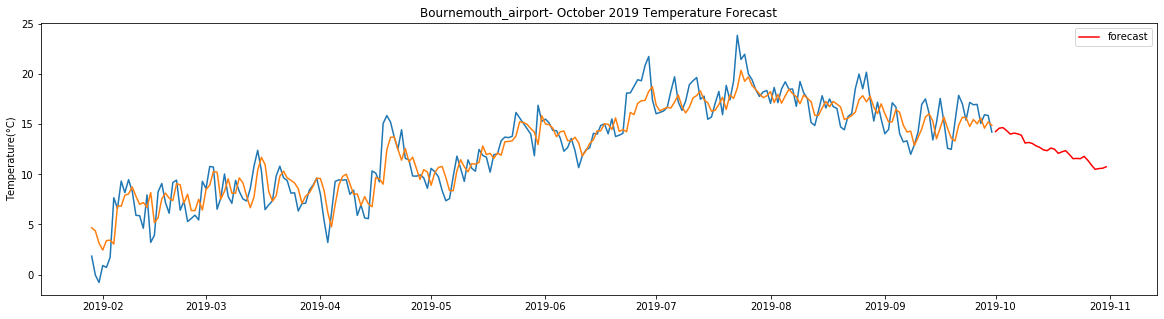

BrizeNorton_airport total row:  5355
split_row:  4819
Train on 4699 samples, validate on 416 samples
Epoch 1/100
4699/4699 [==============================] - ETA: 4:54 - loss: 0.338 - ETA: 29s - loss: 0.293 - ETA: 13s - loss: 0.28 - ETA: 8s - loss: 0.2686 - ETA: 5s - loss: 0.251 - ETA: 3s - loss: 0.225 - ETA: 2s - loss: 0.194 - ETA: 1s - loss: 0.172 - ETA: 0s - loss: 0.157 - ETA: 0s - loss: 0.144 - 5s 1ms/sample - loss: 0.1404 - val_loss: 0.0298
Epoch 2/100
4699/4699 [==============================] - ETA: 0s - loss: 0.037 - ETA: 0s - loss: 0.034 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.030 - ETA: 0s - loss: 0.028 - ETA: 0s - loss: 0.026 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.023 - ETA: 0s - loss: 0.022 - 1s 112us/sample - loss: 0.0222 - val_loss: 0.0096
Epoch 3/100
4699/4699 [==============================] - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ET

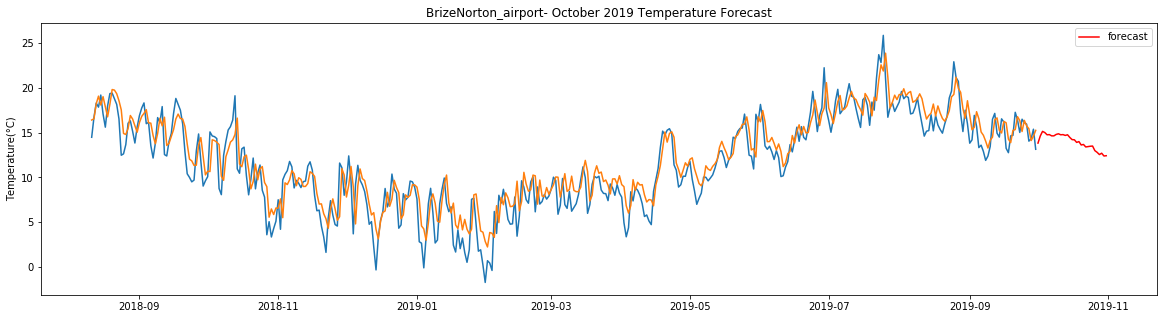

Cardiff_airport total row:  2556
split_row:  2300
Train on 2180 samples, validate on 136 samples
Epoch 1/100
2180/2180 [==============================] - ETA: 2:20 - loss: 0.321 - ETA: 14s - loss: 0.306 - ETA: 5s - loss: 0.2939 - ETA: 2s - loss: 0.280 - ETA: 0s - loss: 0.263 - 5s 2ms/sample - loss: 0.2437 - val_loss: 0.1715
Epoch 2/100
2180/2180 [==============================] - ETA: 0s - loss: 0.083 - ETA: 0s - loss: 0.054 - ETA: 0s - loss: 0.048 - ETA: 0s - loss: 0.044 - ETA: 0s - loss: 0.042 - 0s 122us/sample - loss: 0.0412 - val_loss: 0.0346
Epoch 3/100
2180/2180 [==============================] - ETA: 0s - loss: 0.027 - ETA: 0s - loss: 0.030 - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.028 - ETA: 0s - loss: 0.028 - ETA: 0s - loss: 0.027 - 0s 139us/sample - loss: 0.0272 - val_loss: 0.0236
Epoch 4/100
2180/2180 [==============================] - ETA: 0s - loss: 0.020 - ETA: 0s - loss: 0.017 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.016 - ETA: 0s - loss: 0.015 - 0s 126us/sample - l

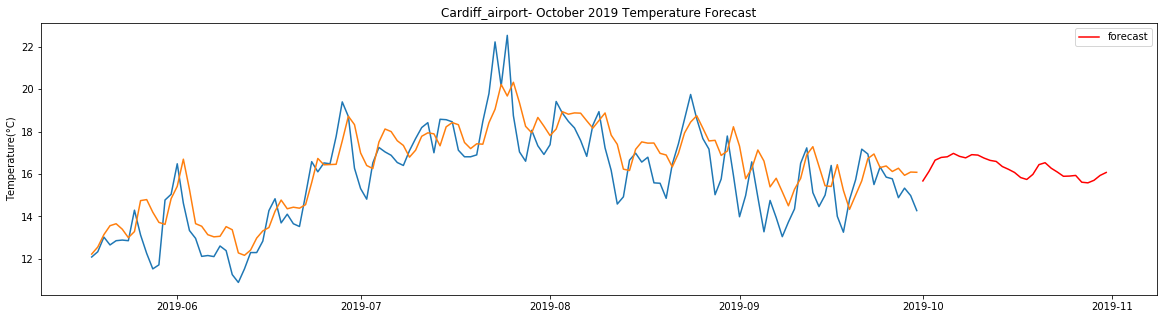

Carlisle total row:  3529
split_row:  3176
Train on 3056 samples, validate on 233 samples
Epoch 1/100
3056/3056 [==============================] - ETA: 3:27 - loss: 0.416 - ETA: 22s - loss: 0.401 - ETA: 9s - loss: 0.3822 - ETA: 5s - loss: 0.367 - ETA: 3s - loss: 0.350 - ETA: 1s - loss: 0.322 - ETA: 1s - loss: 0.313 - ETA: 0s - loss: 0.292 - 6s 2ms/sample - loss: 0.2614 - val_loss: 0.0287
Epoch 2/100
3056/3056 [==============================] - ETA: 0s - loss: 0.038 - ETA: 0s - loss: 0.055 - ETA: 0s - loss: 0.048 - ETA: 0s - loss: 0.040 - ETA: 0s - loss: 0.037 - ETA: 0s - loss: 0.036 - ETA: 0s - loss: 0.034 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.032 - 1s 185us/sample - loss: 0.0327 - val_loss: 0.0212
Epoch 3/100
3056/3056 [==============================] - ETA: 0s - loss: 0.026 - ETA: 0s - loss: 0.028 - ETA: 0s - loss: 0.026 - ETA: 0s - loss: 0.027 - ETA: 0s - loss: 0.027 - ETA: 0s - loss: 0.027 - ETA: 0s - loss: 0.027 - ETA: 0s - loss: 0.027 - ETA: 0s - los

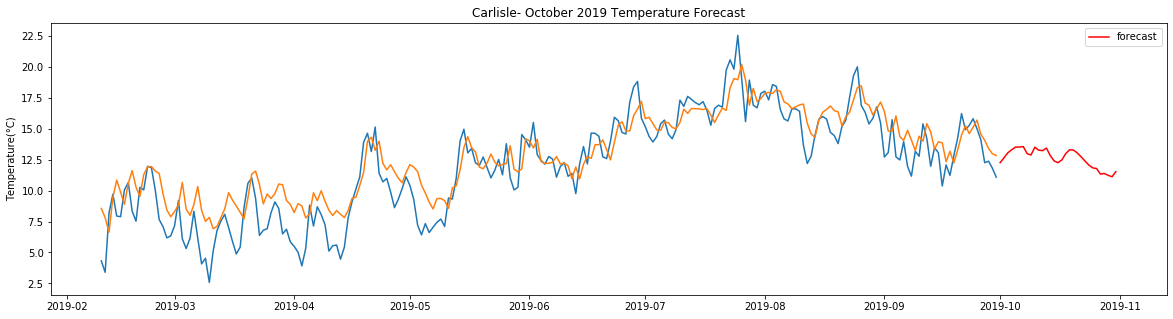

Crosby total row:  3648
split_row:  3283
Train on 3163 samples, validate on 245 samples
Epoch 1/100
3163/3163 [==============================] - ETA: 3:43 - loss: 0.370 - ETA: 24s - loss: 0.355 - ETA: 10s - loss: 0.33 - ETA: 6s - loss: 0.3207 - ETA: 3s - loss: 0.298 - ETA: 2s - loss: 0.268 - ETA: 0s - loss: 0.231 - ETA: 0s - loss: 0.204 - 6s 2ms/sample - loss: 0.2029 - val_loss: 0.0322
Epoch 2/100
3163/3163 [==============================] - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.030 - ETA: 0s - loss: 0.030 - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.028 - ETA: 0s - loss: 0.028 - 0s 124us/sample - loss: 0.0280 - val_loss: 0.0235
Epoch 3/100
3163/3163 [==============================] - ETA: 0s - loss: 0.028 - ETA: 0s - loss: 0.025 - ETA: 0s - loss: 0.025 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.023 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.021 - ETA: 0s - loss: 0.020 - 0s 131us/sample - loss: 0.0202 - val_loss: 0.0104
Epoch 4/100
3163/3163 [==============

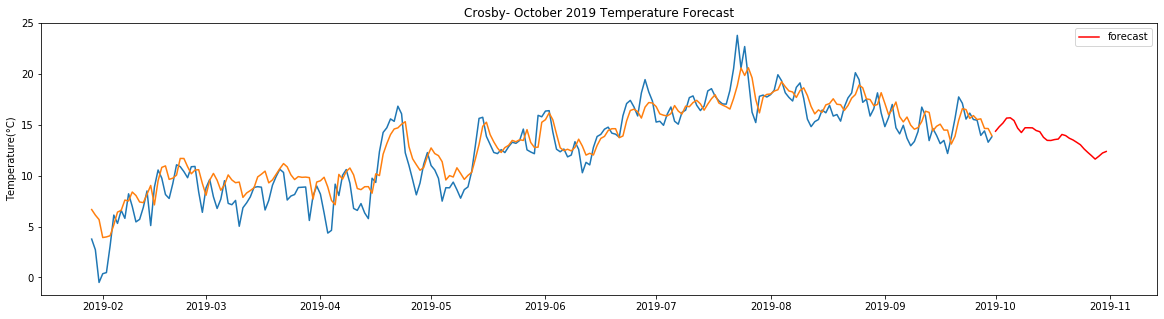

Culdrose_airport total row:  2556
split_row:  2300
Train on 2180 samples, validate on 136 samples
Epoch 1/100
2180/2180 [==============================] - ETA: 2:41 - loss: 0.390 - ETA: 16s - loss: 0.354 - ETA: 7s - loss: 0.3531 - ETA: 3s - loss: 0.326 - ETA: 1s - loss: 0.308 - ETA: 0s - loss: 0.289 - 6s 3ms/sample - loss: 0.2888 - val_loss: 0.2587
Epoch 2/100
2180/2180 [==============================] - ETA: 0s - loss: 0.105 - ETA: 0s - loss: 0.073 - ETA: 0s - loss: 0.060 - ETA: 0s - loss: 0.055 - ETA: 0s - loss: 0.050 - 0s 136us/sample - loss: 0.0480 - val_loss: 0.0585
Epoch 3/100
2180/2180 [==============================] - ETA: 0s - loss: 0.041 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.032 - 0s 132us/sample - loss: 0.0322 - val_loss: 0.0415
Epoch 4/100
2180/2180 [==============================] - ETA: 0s - loss: 0.025 - ETA: 0s - loss: 0.025 - ETA: 0s - loss: 0.025 - ETA: 0s - loss: 0.023 - ETA: 0s - loss: 0.022 - 0s 131us/sample - 

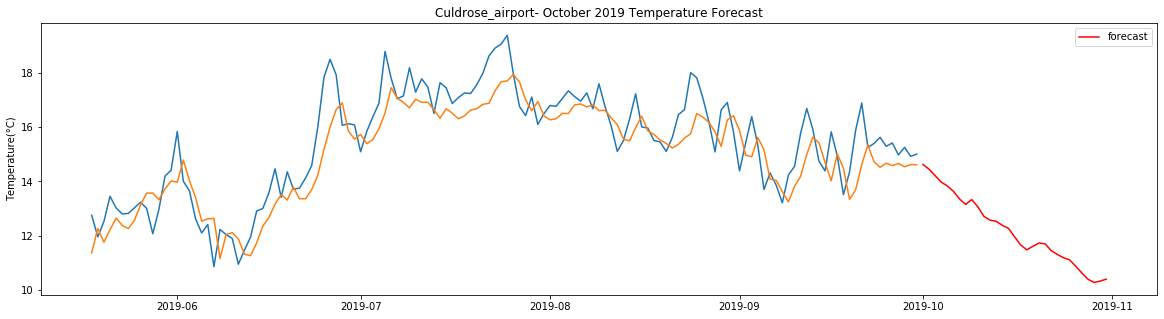

DurhamTeesValley_airport total row:  2556
split_row:  2300
Train on 2180 samples, validate on 136 samples
Epoch 1/100
2180/2180 [==============================] - ETA: 2:44 - loss: 0.293 - ETA: 19s - loss: 0.283 - ETA: 8s - loss: 0.2695 - ETA: 3s - loss: 0.258 - ETA: 1s - loss: 0.242 - ETA: 0s - loss: 0.220 - 6s 3ms/sample - loss: 0.2170 - val_loss: 0.1191
Epoch 2/100
2180/2180 [==============================] - ETA: 0s - loss: 0.064 - ETA: 0s - loss: 0.046 - ETA: 0s - loss: 0.045 - ETA: 0s - loss: 0.042 - ETA: 0s - loss: 0.040 - ETA: 0s - loss: 0.040 - 0s 145us/sample - loss: 0.0401 - val_loss: 0.0321
Epoch 3/100
2180/2180 [==============================] - ETA: 0s - loss: 0.039 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.030 - 0s 164us/sample - loss: 0.0298 - val_loss: 0.0137
Epoch 4/100
2180/2180 [==============================] - ETA: 0s - loss: 0.026 - ETA: 0s - loss: 0.019 - ETA: 0s - loss: 0.018 - ETA: 0s - 

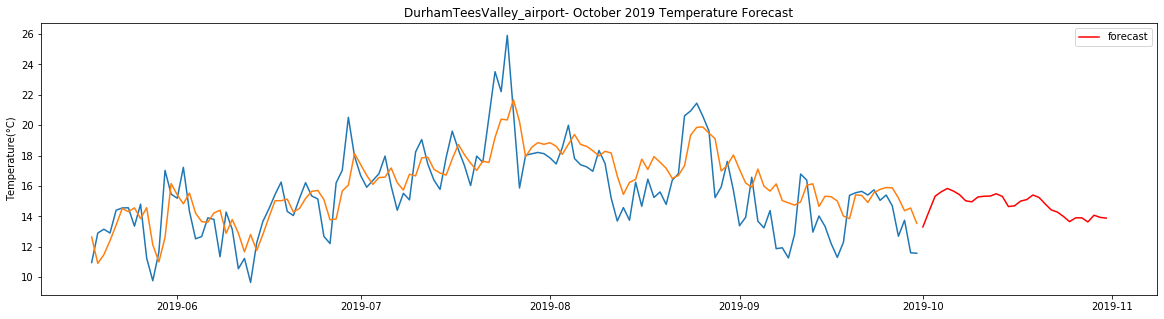

Exeter_airport total row:  2556
split_row:  2300
Train on 2180 samples, validate on 136 samples
Epoch 1/100
2180/2180 [==============================] - ETA: 2:50 - loss: 0.360 - ETA: 20s - loss: 0.342 - ETA: 8s - loss: 0.3291 - ETA: 4s - loss: 0.321 - ETA: 1s - loss: 0.304 - ETA: 0s - loss: 0.287 - 6s 3ms/sample - loss: 0.2778 - val_loss: 0.2338
Epoch 2/100
2180/2180 [==============================] - ETA: 0s - loss: 0.148 - ETA: 0s - loss: 0.101 - ETA: 0s - loss: 0.069 - ETA: 0s - loss: 0.063 - ETA: 0s - loss: 0.056 - ETA: 0s - loss: 0.052 - 0s 151us/sample - loss: 0.0508 - val_loss: 0.0521
Epoch 3/100
2180/2180 [==============================] - ETA: 0s - loss: 0.039 - ETA: 0s - loss: 0.036 - ETA: 0s - loss: 0.035 - ETA: 0s - loss: 0.036 - ETA: 0s - loss: 0.035 - ETA: 0s - loss: 0.033 - 0s 149us/sample - loss: 0.0336 - val_loss: 0.0289
Epoch 4/100
2180/2180 [==============================] - ETA: 0s - loss: 0.034 - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.027 - ETA: 0s - loss: 0.02

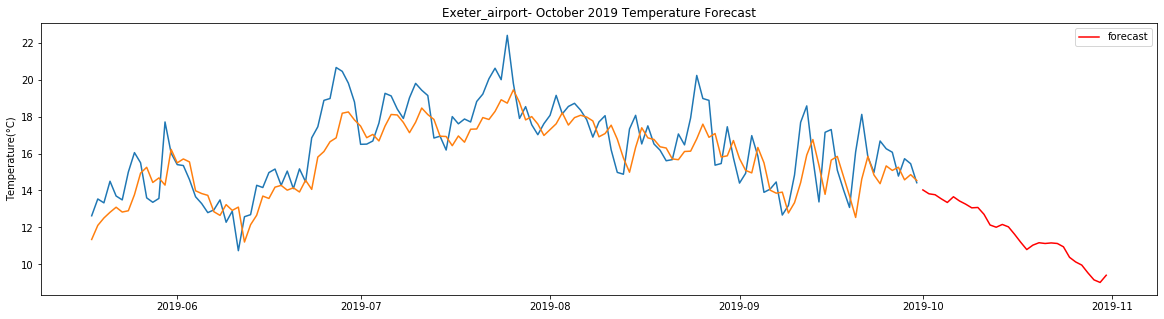

Leconfield_airport total row:  2555
split_row:  2299
Train on 2179 samples, validate on 136 samples
Epoch 1/100
2179/2179 [==============================] - ETA: 2:51 - loss: 0.354 - ETA: 20s - loss: 0.339 - ETA: 8s - loss: 0.3223 - ETA: 4s - loss: 0.304 - ETA: 1s - loss: 0.292 - ETA: 0s - loss: 0.274 - 6s 3ms/sample - loss: 0.2635 - val_loss: 0.1903
Epoch 2/100
2179/2179 [==============================] - ETA: 0s - loss: 0.114 - ETA: 0s - loss: 0.073 - ETA: 0s - loss: 0.059 - ETA: 0s - loss: 0.056 - ETA: 0s - loss: 0.051 - ETA: 0s - loss: 0.047 - 0s 156us/sample - loss: 0.0454 - val_loss: 0.0443
Epoch 3/100
2179/2179 [==============================] - ETA: 0s - loss: 0.036 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.031 - 0s 150us/sample - loss: 0.0312 - val_loss: 0.0281
Epoch 4/100
2179/2179 [==============================] - ETA: 0s - loss: 0.025 - ETA: 0s - loss: 0.023 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 

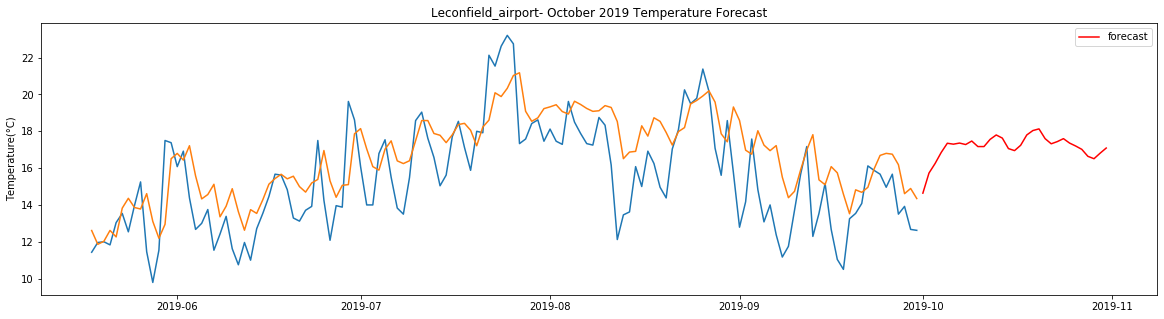

SpadeadamKingwater_airport total row:  2556
split_row:  2300
Train on 2180 samples, validate on 136 samples
Epoch 1/100
2180/2180 [==============================] - ETA: 2:57 - loss: 0.228 - ETA: 25s - loss: 0.222 - ETA: 10s - loss: 0.20 - ETA: 4s - loss: 0.1979 - ETA: 3s - loss: 0.190 - ETA: 1s - loss: 0.176 - ETA: 0s - loss: 0.159 - 7s 3ms/sample - loss: 0.1596 - val_loss: 0.1116
Epoch 2/100
2180/2180 [==============================] - ETA: 0s - loss: 0.044 - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.030 - 0s 189us/sample - loss: 0.0305 - val_loss: 0.0444
Epoch 3/100
2180/2180 [==============================] - ETA: 0s - loss: 0.023 - ETA: 0s - loss: 0.023 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.024 - 0s 152us/sample - loss: 0.0236 - val_loss: 0.0219
Epoch 4/100
2180/2180 [==============================] - ETA: 0s 

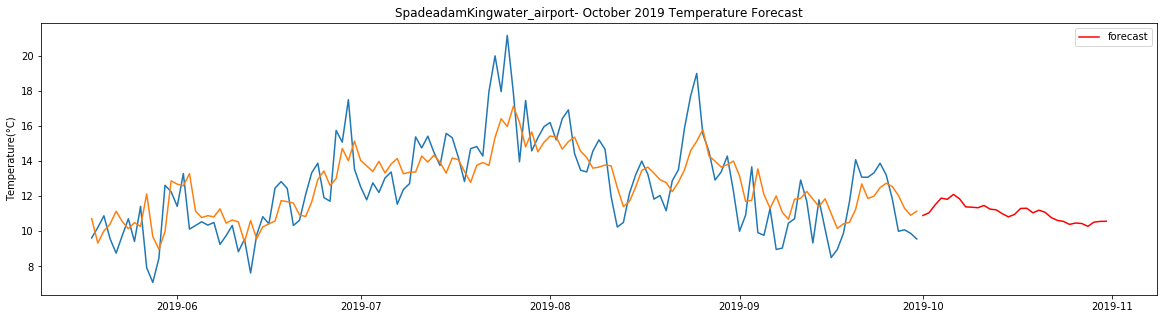

LeedsBradford_airport total row:  2922
split_row:  2629
Train on 2509 samples, validate on 173 samples
Epoch 1/100
2509/2509 [==============================] - ETA: 3:40 - loss: 0.259 - ETA: 32s - loss: 0.283 - ETA: 13s - loss: 0.27 - ETA: 6s - loss: 0.2645 - ETA: 3s - loss: 0.252 - ETA: 2s - loss: 0.238 - ETA: 0s - loss: 0.223 - 7s 3ms/sample - loss: 0.2050 - val_loss: 0.0529
Epoch 2/100
2509/2509 [==============================] - ETA: 0s - loss: 0.053 - ETA: 0s - loss: 0.039 - ETA: 0s - loss: 0.042 - ETA: 0s - loss: 0.038 - ETA: 0s - loss: 0.037 - ETA: 0s - loss: 0.037 - ETA: 0s - loss: 0.036 - 0s 156us/sample - loss: 0.0356 - val_loss: 0.0173
Epoch 3/100
2509/2509 [==============================] - ETA: 0s - loss: 0.037 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.028 - ETA: 0s - loss: 0.027 - ETA: 0s - loss: 0.026 - ETA: 0s - loss: 0.025 - 0s 155us/sample - loss: 0.0241 - val_loss: 0.0088
Epoch 4/100
2509/2509 [==============================] - ETA: 0s - los

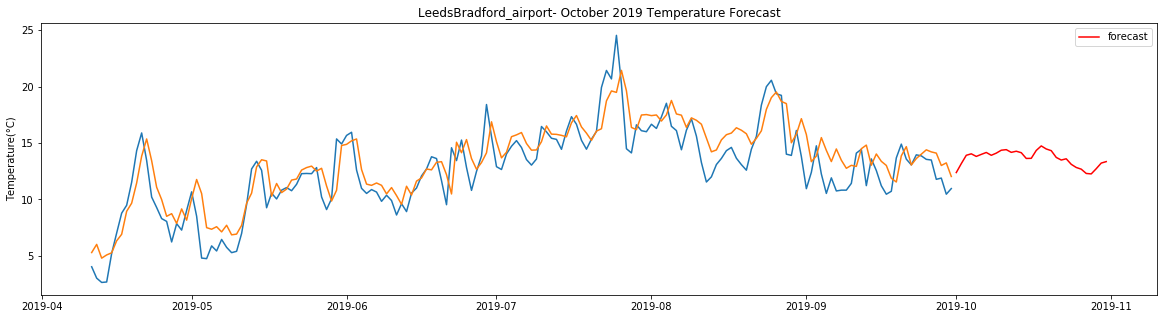

LondonCity_airport total row:  2556
split_row:  2300
Train on 2180 samples, validate on 136 samples
Epoch 1/100
2180/2180 [==============================] - ETA: 3:09 - loss: 0.289 - ETA: 26s - loss: 0.286 - ETA: 12s - loss: 0.27 - ETA: 5s - loss: 0.2610 - ETA: 2s - loss: 0.247 - ETA: 1s - loss: 0.236 - ETA: 0s - loss: 0.223 - 7s 3ms/sample - loss: 0.2200 - val_loss: 0.1431
Epoch 2/100
2180/2180 [==============================] - ETA: 0s - loss: 0.090 - ETA: 0s - loss: 0.062 - ETA: 0s - loss: 0.053 - ETA: 0s - loss: 0.049 - ETA: 0s - loss: 0.046 - ETA: 0s - loss: 0.044 - 0s 161us/sample - loss: 0.0434 - val_loss: 0.0300
Epoch 3/100
2180/2180 [==============================] - ETA: 0s - loss: 0.041 - ETA: 0s - loss: 0.034 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.031 - ETA: 0s - loss: 0.030 - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.028 - 0s 171us/sample - loss: 0.0281 - val_loss: 0.0113
Epoch 4/100
2180/2180 [==============================] - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 

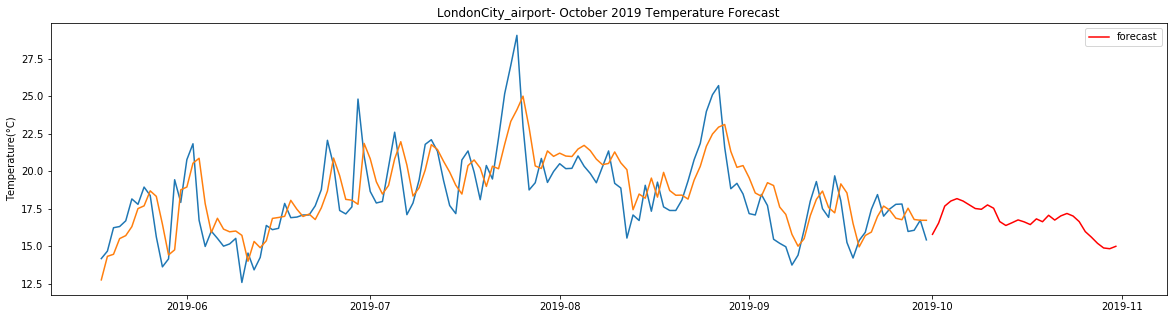

Lyneham_airport total row:  5355
split_row:  4819
Train on 4699 samples, validate on 416 samples
Epoch 1/100
4699/4699 [==============================] - ETA: 7:14 - loss: 0.339 - ETA: 2:22 - loss: 0.291 - ETA: 1:23 - loss: 0.284 - ETA: 50s - loss: 0.276 - ETA: 31s - loss: 0.26 - ETA: 22s - loss: 0.26 - ETA: 19s - loss: 0.26 - ETA: 14s - loss: 0.25 - ETA: 10s - loss: 0.24 - ETA: 7s - loss: 0.2280 - ETA: 6s - loss: 0.213 - ETA: 4s - loss: 0.194 - ETA: 3s - loss: 0.178 - ETA: 2s - loss: 0.171 - ETA: 2s - loss: 0.159 - ETA: 1s - loss: 0.149 - ETA: 0s - loss: 0.140 - ETA: 0s - loss: 0.133 - 8s 2ms/sample - loss: 0.1297 - val_loss: 0.0301
Epoch 2/100
4699/4699 [==============================] - ETA: 1s - loss: 0.029 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.030 - ETA: 0s - loss: 0.028 - ETA: 0s - loss: 0.028 - ETA: 0s - loss: 0.027 - ETA: 0s - loss: 0.026 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.023 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.021 - ETA: 0s - los

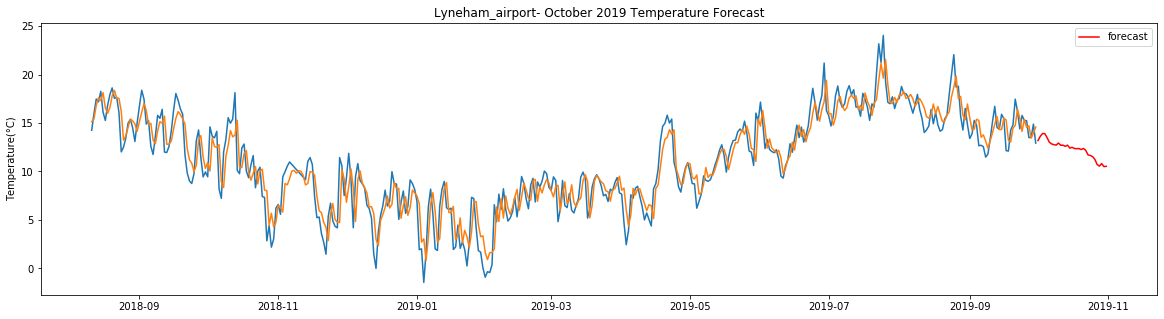

NewquayCornwall_airport total row:  2556
split_row:  2300
Train on 2180 samples, validate on 136 samples
Epoch 1/100
2180/2180 [==============================] - ETA: 3:35 - loss: 0.308 - ETA: 38s - loss: 0.291 - ETA: 15s - loss: 0.28 - ETA: 8s - loss: 0.2696 - ETA: 6s - loss: 0.263 - ETA: 3s - loss: 0.253 - ETA: 1s - loss: 0.236 - ETA: 0s - loss: 0.219 - 8s 4ms/sample - loss: 0.2147 - val_loss: 0.1188
Epoch 2/100
2180/2180 [==============================] - ETA: 0s - loss: 0.062 - ETA: 0s - loss: 0.044 - ETA: 0s - loss: 0.037 - ETA: 0s - loss: 0.037 - ETA: 0s - loss: 0.034 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.031 - 0s 202us/sample - loss: 0.0310 - val_loss: 0.0283
Epoch 3/100
2180/2180 [==============================] - ETA: 0s - loss: 0.027 - ETA: 0s - loss: 0.025 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.024 - ETA: 0s - loss: 0.023 - ETA: 0s - loss: 0.023 - ETA: 0s - loss: 0.022 - ETA: 0s - loss: 0.022 - 0s 200us/sample - loss: 0.0226 - val_loss: 0.0

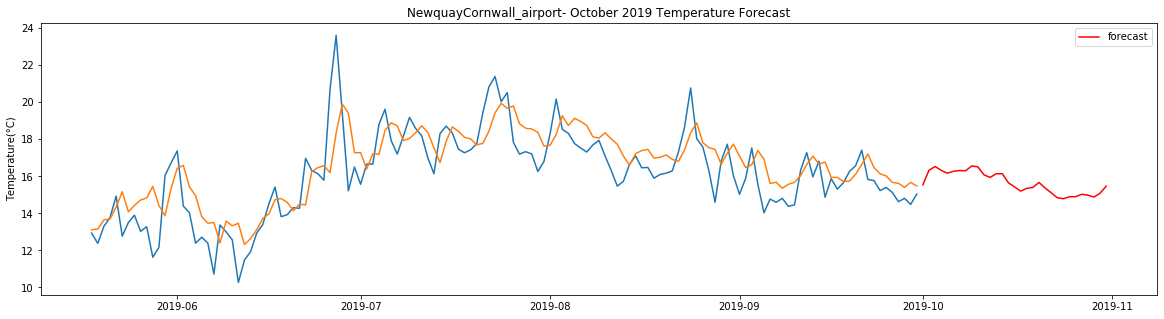

Norwich_airport total row:  2556
split_row:  2300
Train on 2180 samples, validate on 136 samples
Epoch 1/100
2180/2180 [==============================] - ETA: 3:39 - loss: 0.367 - ETA: 38s - loss: 0.334 - ETA: 18s - loss: 0.32 - ETA: 11s - loss: 0.31 - ETA: 6s - loss: 0.3095 - ETA: 4s - loss: 0.300 - ETA: 2s - loss: 0.291 - ETA: 1s - loss: 0.281 - ETA: 0s - loss: 0.265 - 8s 4ms/sample - loss: 0.2574 - val_loss: 0.1662
Epoch 2/100
2180/2180 [==============================] - ETA: 0s - loss: 0.096 - ETA: 0s - loss: 0.073 - ETA: 0s - loss: 0.058 - ETA: 0s - loss: 0.053 - ETA: 0s - loss: 0.051 - ETA: 0s - loss: 0.049 - ETA: 0s - loss: 0.047 - ETA: 0s - loss: 0.045 - ETA: 0s - loss: 0.044 - 1s 238us/sample - loss: 0.0443 - val_loss: 0.0321
Epoch 3/100
2180/2180 [==============================] - ETA: 0s - loss: 0.036 - ETA: 0s - loss: 0.036 - ETA: 0s - loss: 0.035 - ETA: 0s - loss: 0.034 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.032 - ETA: 0

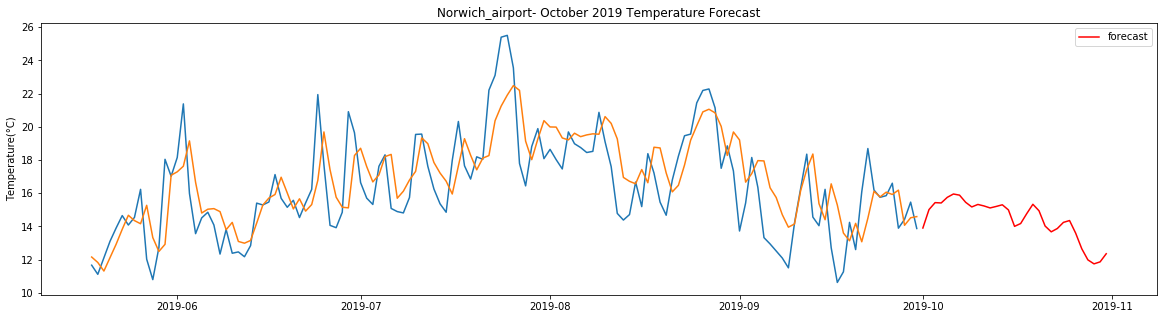

Nottingham total row:  5355
split_row:  4819
Train on 4699 samples, validate on 416 samples
Epoch 1/100
4699/4699 [==============================] - ETA: 8:13 - loss: 0.310 - ETA: 1:59 - loss: 0.285 - ETA: 56s - loss: 0.285 - ETA: 35s - loss: 0.27 - ETA: 25s - loss: 0.27 - ETA: 20s - loss: 0.26 - ETA: 16s - loss: 0.25 - ETA: 13s - loss: 0.24 - ETA: 11s - loss: 0.23 - ETA: 8s - loss: 0.2259 - ETA: 7s - loss: 0.214 - ETA: 6s - loss: 0.199 - ETA: 5s - loss: 0.188 - ETA: 4s - loss: 0.176 - ETA: 3s - loss: 0.165 - ETA: 2s - loss: 0.159 - ETA: 2s - loss: 0.152 - ETA: 1s - loss: 0.144 - ETA: 1s - loss: 0.137 - ETA: 0s - loss: 0.133 - ETA: 0s - loss: 0.127 - 9s 2ms/sample - loss: 0.1255 - val_loss: 0.0241
Epoch 2/100
4699/4699 [==============================] - ETA: 1s - loss: 0.030 - ETA: 1s - loss: 0.030 - ETA: 1s - loss: 0.031 - ETA: 1s - loss: 0.030 - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.029 - ETA: 0s - loss: 0.028 - ETA: 0s - loss: 0.028 - ETA: 0s - loss: 0.02

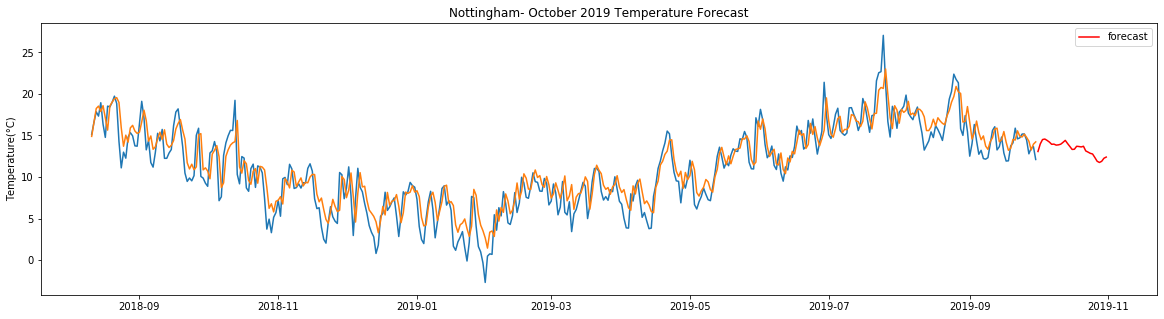

Plymouth_weatherstation total row:  5355
split_row:  4819
Train on 4699 samples, validate on 416 samples
Epoch 1/100
4699/4699 [==============================] - ETA: 8:57 - loss: 0.333 - ETA: 1:42 - loss: 0.309 - ETA: 1:01 - loss: 0.309 - ETA: 43s - loss: 0.298 - ETA: 32s - loss: 0.29 - ETA: 25s - loss: 0.28 - ETA: 20s - loss: 0.27 - ETA: 17s - loss: 0.26 - ETA: 14s - loss: 0.25 - ETA: 12s - loss: 0.24 - ETA: 10s - loss: 0.23 - ETA: 8s - loss: 0.2257 - ETA: 7s - loss: 0.213 - ETA: 6s - loss: 0.200 - ETA: 5s - loss: 0.189 - ETA: 4s - loss: 0.180 - ETA: 3s - loss: 0.172 - ETA: 3s - loss: 0.165 - ETA: 2s - loss: 0.158 - ETA: 2s - loss: 0.151 - ETA: 1s - loss: 0.147 - ETA: 1s - loss: 0.142 - ETA: 0s - loss: 0.137 - ETA: 0s - loss: 0.133 - ETA: 0s - loss: 0.128 - 10s 2ms/sample - loss: 0.1282 - val_loss: 0.0298
Epoch 2/100
4699/4699 [==============================] - ETA: 2s - loss: 0.039 - ETA: 1s - loss: 0.032 - ETA: 1s - loss: 0.030 - ETA: 1s - loss: 0.031 - ETA: 1s - loss: 0.031 - ETA:

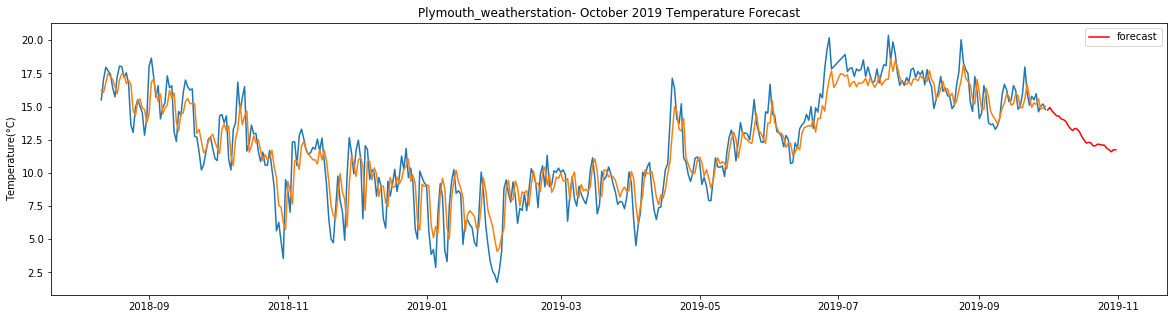

Rostherne total row:  2495
split_row:  2245
Train on 2125 samples, validate on 130 samples
Epoch 1/100
2125/2125 [==============================] - ETA: 4:17 - loss: 0.332 - ETA: 58s - loss: 0.315 - ETA: 30s - loss: 0.30 - ETA: 18s - loss: 0.29 - ETA: 12s - loss: 0.28 - ETA: 8s - loss: 0.2825 - ETA: 6s - loss: 0.272 - ETA: 4s - loss: 0.266 - ETA: 2s - loss: 0.261 - ETA: 1s - loss: 0.257 - ETA: 1s - loss: 0.252 - ETA: 0s - loss: 0.245 - 10s 5ms/sample - loss: 0.2420 - val_loss: 0.1984
Epoch 2/100
2125/2125 [==============================] - ETA: 0s - loss: 0.127 - ETA: 0s - loss: 0.103 - ETA: 0s - loss: 0.086 - ETA: 0s - loss: 0.074 - ETA: 0s - loss: 0.068 - ETA: 0s - loss: 0.064 - ETA: 0s - loss: 0.062 - ETA: 0s - loss: 0.059 - ETA: 0s - loss: 0.057 - ETA: 0s - loss: 0.055 - ETA: 0s - loss: 0.053 - 1s 313us/sample - loss: 0.0522 - val_loss: 0.0343
Epoch 3/100
2125/2125 [==============================] - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.032 - ETA: 0s - loss: 0.031 - ETA: 0s - l

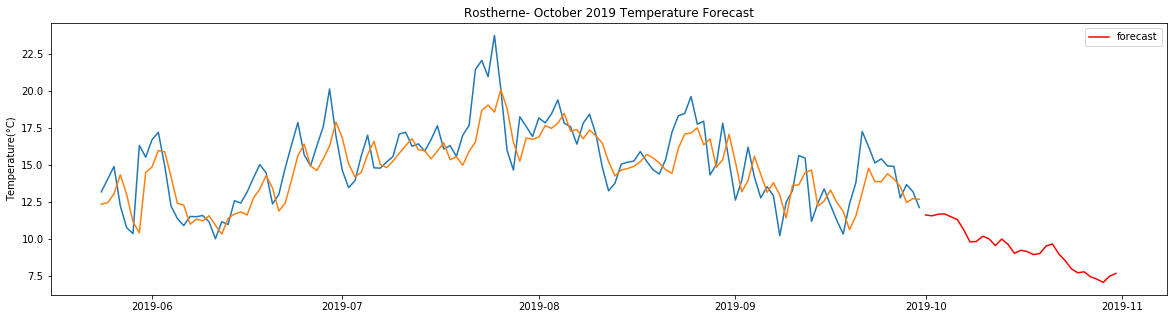

Scampton_airport total row:  3543
split_row:  3188
Train on 3068 samples, validate on 235 samples
Epoch 1/100
3068/3068 [==============================] - ETA: 6:18 - loss: 0.423 - ETA: 1:29 - loss: 0.407 - ETA: 47s - loss: 0.401 - ETA: 31s - loss: 0.39 - ETA: 24s - loss: 0.39 - ETA: 18s - loss: 0.38 - ETA: 13s - loss: 0.37 - ETA: 10s - loss: 0.36 - ETA: 8s - loss: 0.3570 - ETA: 6s - loss: 0.346 - ETA: 5s - loss: 0.332 - ETA: 3s - loss: 0.316 - ETA: 2s - loss: 0.301 - ETA: 2s - loss: 0.283 - ETA: 1s - loss: 0.266 - ETA: 0s - loss: 0.251 - 10s 3ms/sample - loss: 0.2391 - val_loss: 0.0407
Epoch 2/100
3068/3068 [==============================] - ETA: 1s - loss: 0.069 - ETA: 0s - loss: 0.048 - ETA: 0s - loss: 0.044 - ETA: 0s - loss: 0.041 - ETA: 0s - loss: 0.040 - ETA: 0s - loss: 0.038 - ETA: 0s - loss: 0.037 - ETA: 0s - loss: 0.037 - ETA: 0s - loss: 0.036 - ETA: 0s - loss: 0.035 - ETA: 0s - loss: 0.034 - ETA: 0s - loss: 0.034 - ETA: 0s - loss: 0.033 - ETA: 0s - loss: 0.033 - ETA: 0s - los

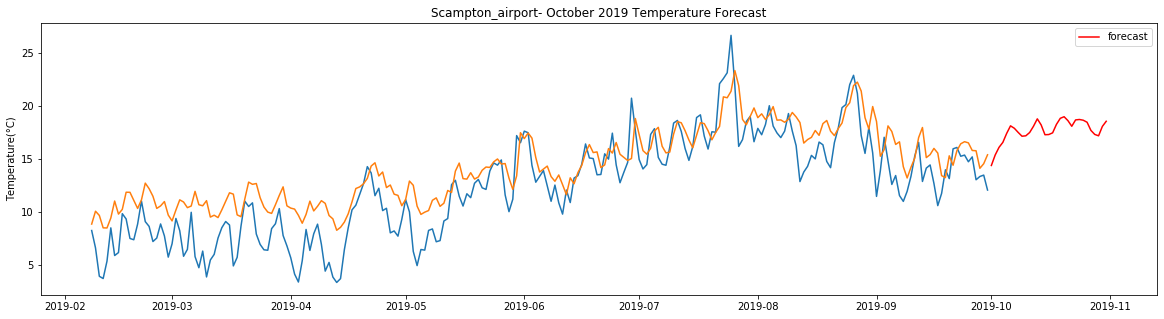

Shawbury_airport total row:  5355
split_row:  4819
Train on 4699 samples, validate on 416 samples
Epoch 1/100
4699/4699 [==============================] - ETA: 10:17 - loss: 0.37 - ETA: 2:29 - loss: 0.3841 - ETA: 1:22 - loss: 0.387 - ETA: 55s - loss: 0.380 - ETA: 40s - loss: 0.37 - ETA: 31s - loss: 0.36 - ETA: 25s - loss: 0.36 - ETA: 22s - loss: 0.35 - ETA: 18s - loss: 0.34 - ETA: 15s - loss: 0.33 - ETA: 13s - loss: 0.32 - ETA: 12s - loss: 0.32 - ETA: 11s - loss: 0.30 - ETA: 9s - loss: 0.2958 - ETA: 8s - loss: 0.284 - ETA: 7s - loss: 0.272 - ETA: 6s - loss: 0.256 - ETA: 5s - loss: 0.241 - ETA: 4s - loss: 0.229 - ETA: 4s - loss: 0.222 - ETA: 3s - loss: 0.212 - ETA: 2s - loss: 0.202 - ETA: 2s - loss: 0.196 - ETA: 1s - loss: 0.188 - ETA: 1s - loss: 0.183 - ETA: 0s - loss: 0.177 - ETA: 0s - loss: 0.170 - ETA: 0s - loss: 0.164 - 12s 2ms/sample - loss: 0.1641 - val_loss: 0.0349
Epoch 2/100
4699/4699 [==============================] - ETA: 2s - loss: 0.026 - ETA: 1s - loss: 0.026 - ETA: 1s - 

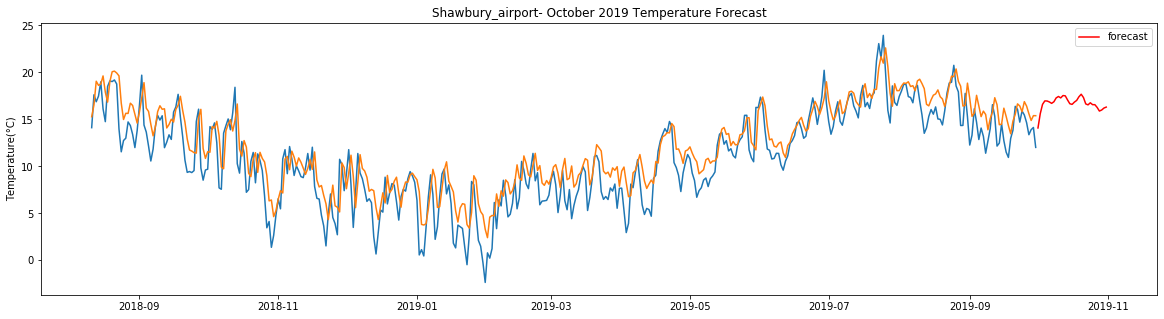

Southend_on_Sea_AWS total row:  3648
split_row:  3283
Train on 3163 samples, validate on 245 samples
Epoch 1/100
3163/3163 [==============================] - ETA: 7:23 - loss: 0.282 - ETA: 1:44 - loss: 0.286 - ETA: 1:07 - loss: 0.289 - ETA: 48s - loss: 0.297 - ETA: 37s - loss: 0.29 - ETA: 29s - loss: 0.29 - ETA: 24s - loss: 0.29 - ETA: 19s - loss: 0.29 - ETA: 18s - loss: 0.29 - ETA: 15s - loss: 0.28 - ETA: 13s - loss: 0.28 - ETA: 11s - loss: 0.28 - ETA: 9s - loss: 0.2778 - ETA: 8s - loss: 0.272 - ETA: 7s - loss: 0.267 - ETA: 5s - loss: 0.260 - ETA: 5s - loss: 0.255 - ETA: 4s - loss: 0.248 - ETA: 3s - loss: 0.242 - ETA: 2s - loss: 0.235 - ETA: 2s - loss: 0.227 - ETA: 1s - loss: 0.219 - ETA: 1s - loss: 0.212 - ETA: 0s - loss: 0.205 - ETA: 0s - loss: 0.199 - 12s 4ms/sample - loss: 0.1980 - val_loss: 0.0345
Epoch 2/100
3163/3163 [==============================] - ETA: 1s - loss: 0.049 - ETA: 2s - loss: 0.055 - ETA: 1s - loss: 0.053 - ETA: 1s - loss: 0.050 - ETA: 1s - loss: 0.048 - ETA: 1s 

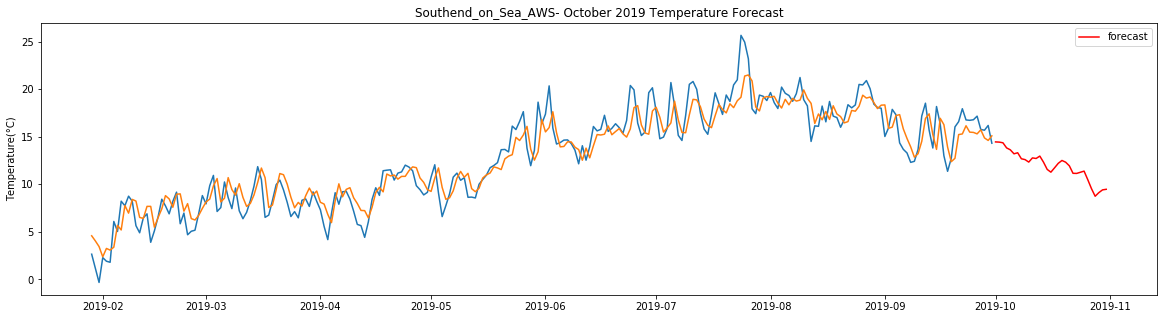

Stansted_airport total row:  2556
split_row:  2300
Train on 2180 samples, validate on 136 samples
Epoch 1/100
2180/2180 [==============================] - ETA: 5:16 - loss: 0.268 - ETA: 1:39 - loss: 0.276 - ETA: 56s - loss: 0.277 - ETA: 37s - loss: 0.27 - ETA: 27s - loss: 0.27 - ETA: 20s - loss: 0.27 - ETA: 16s - loss: 0.27 - ETA: 12s - loss: 0.27 - ETA: 10s - loss: 0.26 - ETA: 7s - loss: 0.2625 - ETA: 6s - loss: 0.257 - ETA: 4s - loss: 0.253 - ETA: 3s - loss: 0.249 - ETA: 2s - loss: 0.243 - ETA: 1s - loss: 0.240 - ETA: 1s - loss: 0.233 - ETA: 0s - loss: 0.228 - 12s 6ms/sample - loss: 0.2245 - val_loss: 0.1119
Epoch 2/100
2180/2180 [==============================] - ETA: 1s - loss: 0.114 - ETA: 0s - loss: 0.078 - ETA: 0s - loss: 0.073 - ETA: 0s - loss: 0.062 - ETA: 0s - loss: 0.056 - ETA: 0s - loss: 0.055 - ETA: 0s - loss: 0.055 - ETA: 0s - loss: 0.054 - ETA: 0s - loss: 0.053 - ETA: 0s - loss: 0.051 - ETA: 0s - loss: 0.050 - ETA: 0s - loss: 0.049 - ETA: 0s - loss: 0.049 - ETA: 0s - los

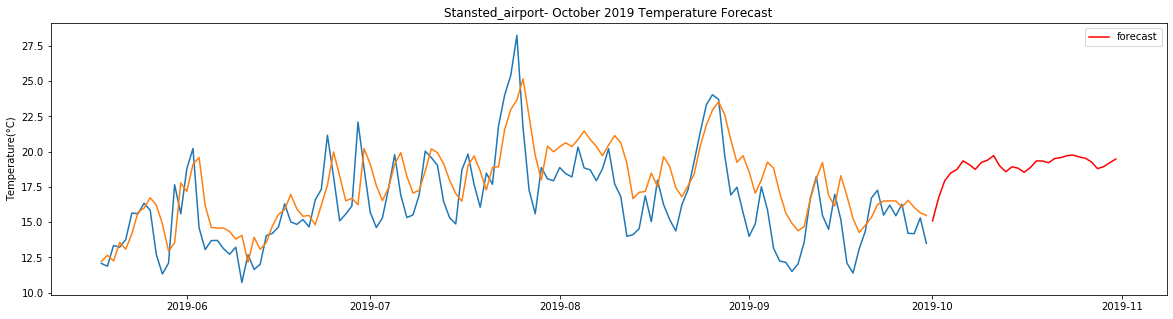

Wittering_airport total row:  5355
split_row:  4819
Train on 4699 samples, validate on 416 samples
Epoch 1/100
4699/4699 [==============================] - ETA: 11:56 - loss: 0.28 - ETA: 3:53 - loss: 0.2970 - ETA: 2:17 - loss: 0.297 - ETA: 1:35 - loss: 0.292 - ETA: 1:12 - loss: 0.298 - ETA: 57s - loss: 0.298 - ETA: 47s - loss: 0.29 - ETA: 40s - loss: 0.28 - ETA: 34s - loss: 0.28 - ETA: 29s - loss: 0.27 - ETA: 26s - loss: 0.27 - ETA: 23s - loss: 0.26 - ETA: 20s - loss: 0.26 - ETA: 18s - loss: 0.25 - ETA: 16s - loss: 0.25 - ETA: 14s - loss: 0.25 - ETA: 13s - loss: 0.24 - ETA: 11s - loss: 0.23 - ETA: 10s - loss: 0.23 - ETA: 9s - loss: 0.2245 - ETA: 9s - loss: 0.220 - ETA: 8s - loss: 0.213 - ETA: 7s - loss: 0.205 - ETA: 6s - loss: 0.197 - ETA: 6s - loss: 0.191 - ETA: 5s - loss: 0.185 - ETA: 4s - loss: 0.179 - ETA: 4s - loss: 0.174 - ETA: 3s - loss: 0.170 - ETA: 3s - loss: 0.165 - ETA: 2s - loss: 0.160 - ETA: 2s - loss: 0.156 - ETA: 1s - loss: 0.152 - ETA: 1s - loss: 0.149 - ETA: 0s - loss:

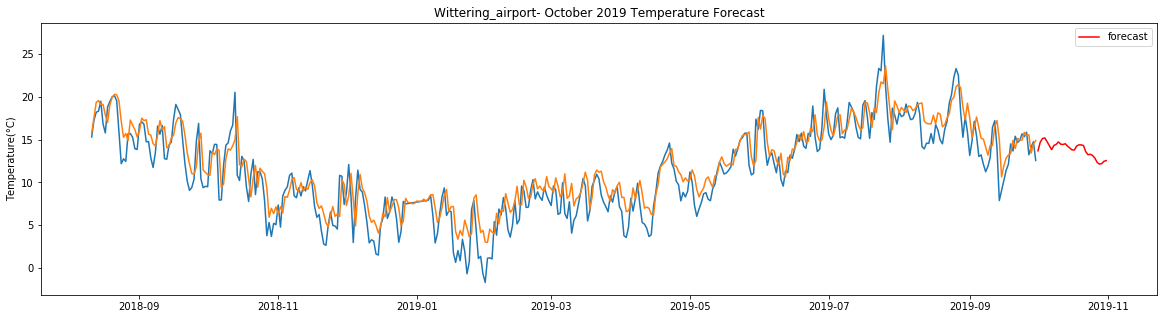

Yeovilton_airport total row:  5355
split_row:  4819
Train on 4699 samples, validate on 416 samples
Epoch 1/100
4699/4699 [==============================] - ETA: 13:04 - loss: 0.31 - ETA: 4:15 - loss: 0.3279 - ETA: 2:29 - loss: 0.340 - ETA: 1:44 - loss: 0.335 - ETA: 1:19 - loss: 0.334 - ETA: 1:03 - loss: 0.327 - ETA: 52s - loss: 0.328 - ETA: 47s - loss: 0.32 - ETA: 40s - loss: 0.31 - ETA: 35s - loss: 0.31 - ETA: 32s - loss: 0.31 - ETA: 30s - loss: 0.30 - ETA: 28s - loss: 0.30 - ETA: 25s - loss: 0.30 - ETA: 24s - loss: 0.30 - ETA: 21s - loss: 0.29 - ETA: 20s - loss: 0.29 - ETA: 19s - loss: 0.29 - ETA: 17s - loss: 0.28 - ETA: 15s - loss: 0.27 - ETA: 14s - loss: 0.27 - ETA: 12s - loss: 0.26 - ETA: 11s - loss: 0.25 - ETA: 10s - loss: 0.24 - ETA: 9s - loss: 0.2389 - ETA: 9s - loss: 0.234 - ETA: 8s - loss: 0.224 - ETA: 7s - loss: 0.216 - ETA: 6s - loss: 0.208 - ETA: 5s - loss: 0.202 - ETA: 5s - loss: 0.199 - ETA: 4s - loss: 0.193 - ETA: 4s - loss: 0.187 - ETA: 3s - loss: 0.181 - ETA: 3s - los

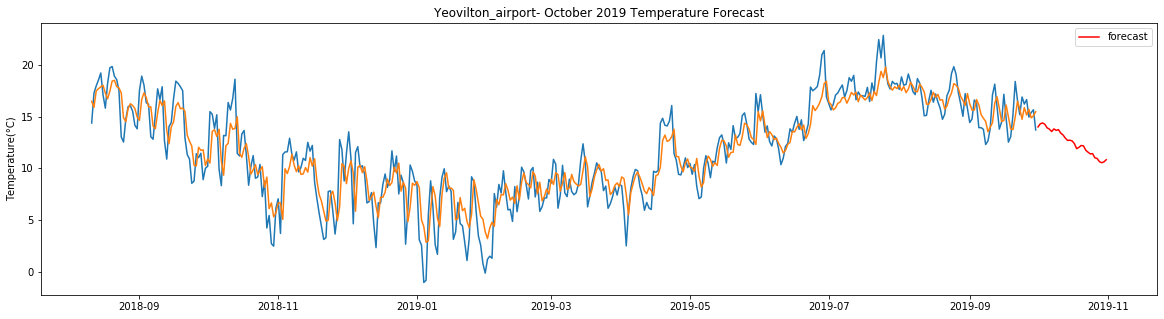

Wall time: 46min 13s


In [21]:
%%time
# Fitting and forecast using LSTM
lstm_prediction = england_temp_lstm(all_station_temp,120,31)

The result above gives model metrics of the fitted data for each weather station followed by visualization of the output and the monthly forecast, with past observed temperatures in Blue, validation in Orange and forecast in Red. It can be seen that the data are fitted with reasonable high accuracy for most of the stations. 

### Temperature forecasted by LSTM model <a class="anchor" id="12"></a>

The output forecasted temperature for the weather stations by the model is as follows:   

In [22]:
# 30 days of forecast for October,2019 obtained from the LSTM model for each weather stations
lstm_prediction.head()

Albemarle  Begwary  Birmingham_airport  Blackpool_airport  \
2019-10-01      10.87    12.86               13.33              13.90   
2019-10-02      11.20    12.87               13.89              14.22   
2019-10-03      11.23    13.03               15.03              14.49   
2019-10-04      11.32    12.82               15.35              14.70   
2019-10-05      11.67    12.87               15.15              14.65   

            Boulmer_airport  Bournemouth_airport  BrizeNorton_airport  \
2019-10-01            15.43                14.27                13.83   
2019-10-02            15.95                14.61                14.62   
2019-10-03            16.07                14.67                15.14   
2019-10-04            15.80                14.37                15.01   
2019-10-05            15.95                14.02                14.76   

            Cardiff_airport  Carlisle  Crosby  ...  Norwich_airport  \
2019-10-01        15.670000     12.25   14.37  ...            13.90   
2019-10-02        16.120001     12.64   14.81  ...            15.01   
2019-10-03        16.650000     13.05   15.17  ...            15.43   
2019-10-04        16.780001     13.29   15.66  ...            15.41   
2019-10-05        16.809999     13.51   15.69  ...            15.75   

            Nottingham  Plymouth_weatherstation  Rostherne  Scampton_airport  \
2019-10-01       13.07                    14.74      11.62         14.400000   
2019-10-02       13.98                    14.93      11.56         15.390000   
2019-10-03       14.51                    14.65      11.67         16.110001   
2019-10-04       14.57                    14.47      11.69         16.580000   
2019-10-05       14.41                    14.30      11.49         17.430000   

            Shawbury_airport  Southend_on_Sea_AWS  Stansted_airport  \
2019-10-01         14.090000                14.45         15.090000   
2019-10-02         15.610000                14.43         16.730000   
2019-10-03         16.600000                14.36         17.940001   
2019-10-04         16.969999                13.82         18.500000   
2019-10-05         16.959999                13.62         18.740000   

            Wittering_airport  Yeovilton_airport  
2019-10-01              13.68              13.99  
2019-10-02              14.69              14.29  
2019-10-03              15.12              14.38  
2019-10-04              15.19              14.25  
2019-10-05              14.76              13.91  

[5 rows x 29 columns]

## Support Vector Machine <a class="anchor" id="13"></a>

In the second method a machine learning algorithm of Support Vector Regression(SVR) is applied to compare performances obtained by the deep learning framework. Similarly a function is first created which would first receive the time series data, followed by fitting it using the ML model and forecasting for the same time period. 

In [23]:
def england_temp_svr(all_station_temp, lag, days):
    
    
    # create future forecast dates
    v = pd.date_range(start='2019-09-30', periods=days+1, freq='D', closed='right')
    seven_day_forecast_svr = pd.DataFrame(index=v)
    
    for i in range(len(all_station_temp.columns)):
        
        # Data preparation
        station_value = all_station_temp[[all_station_temp.columns[i]]].dropna()
        station_name = all_station_temp.columns[i]

        
        nrow = len(station_value)
        print(station_name+' total row: ',nrow)
        split_row = int((nrow)*.80)
        print('split_row: ',split_row)
    
        train_tract1 = station_value.iloc[:split_row]
        test_tract1 = station_value.iloc[split_row:]

        
        scaler = MinMaxScaler()
        train_tract1_scaled = scaler.fit_transform(train_tract1)
        test_tract1_scaled = scaler.fit_transform(test_tract1)

        train_tract1_scaled_df = pd.DataFrame(train_tract1_scaled, index = train_tract1.index, columns=[train_tract1.columns[0]])
        test_tract1_scaled_df = pd.DataFrame(test_tract1_scaled, index = test_tract1.index, columns=[test_tract1.columns[0]])

        
        train_tract1 = timeseries_feature_builder(train_tract1_scaled_df,lag+1)
        test_tract1 = timeseries_feature_builder(test_tract1_scaled_df, lag+1)

        X_train_tract1 = train_tract1.dropna().drop(train_tract1.columns[0], axis=1)
        y_train_tract1 = train_tract1.dropna()[train_tract1.columns[0]]

        X_test_tract1 = test_tract1.dropna().drop(test_tract1.columns[0], axis=1)
        y_test_tract1 = test_tract1.dropna()[test_tract1.columns[0]]

        
        X_train_tract1_array = X_train_tract1.values
        y_train_tract1_array = y_train_tract1.values


        X_test_tract1_array = X_test_tract1.values
        y_test_tract1_array = y_test_tract1.values

        
        # Fitting SVR
        model_svr = SVR(kernel='rbf', degree=2, gamma='auto', tol=0.001, C=10.0, epsilon=0.001)

        model_svr.fit(X_train_tract1_array,y_train_tract1_array)

        y_pred_train_tract1 = model_svr.predict(X_train_tract1_array)
        y_pred_test_tract1 = model_svr.predict(X_test_tract1_array)
        
        
        print('\nTraining metrics for SVR model')
        print('r-square_SVR_Train: ', round(model_svr.score(X_train_tract1_array,y_train_tract1_array),2))


        mse_SVR_Train = metrics.mean_squared_error(y_train_tract1_array, y_pred_train_tract1)  
        print('RMSE_SVR_Train: ', round(np.sqrt(mse_SVR_Train),2))

        mean_absolute_error_SVR_Train = metrics.mean_absolute_error(y_train_tract1_array, y_pred_train_tract1)
        print('MAE_SVR_Train: ', round(mean_absolute_error_SVR_Train,2))

        
        print('\nTest metrics for SVR model')
        print('r-square_SVR_Test: ', round(model_svr.score(X_test_tract1_array,y_test_tract1_array),2))

        mse_SVR_test = metrics.mean_squared_error(y_test_tract1_array, y_pred_test_tract1)
        print('mse_SVR_test: ', round(np.sqrt(mse_SVR_test), 2))

        mean_absolute_error_SVR_test = metrics.mean_absolute_error(y_test_tract1_array, y_pred_test_tract1)
        print('MAE_SVR_test: ', round(mean_absolute_error_SVR_test, 2))

        
        
        last_test_sample = X_test_tract1_array[-1]        
        X_last_test_sample = np.reshape(last_test_sample,(-1,X_test_tract1_array.shape[1]))        
        X_last_test_sample.shape
        
        y_pred_last_sample = model_svr.predict(X_last_test_sample)
        
                
        new_array = X_last_test_sample
        new_predict = y_pred_last_sample        


        # previous lag number of data points are used to predict the next point
        new_test_tract1 = station_value.iloc[split_row:]        
        test_tract1_pred = new_test_tract1.iloc[lag:].copy()
        y_pred_test_tract1_transformed = scaler.inverse_transform([y_pred_test_tract1])
        y_pred_test_tract1_transformed_reshaped = np.reshape(y_pred_test_tract1_transformed,(y_pred_test_tract1_transformed.shape[1],-1))
        
        print(test_tract1_pred.shape)
        print(y_pred_test_tract1_transformed.shape)
        print(y_pred_test_tract1_transformed_reshaped.shape)
        test_tract1_pred['Forecast'] = np.array(y_pred_test_tract1_transformed_reshaped)              
        
        
        # multi-step future forecast
        new_array = X_last_test_sample
        new_predict = y_pred_last_sample

        seven_days_svr=[]

        for i in range(0,days):
    
                # inserting predicted value to begining of the array
                new_array = np.insert(new_array, 0, new_predict)

                # deleting the last item 
                new_array = np.delete(new_array, -1)
                new_array_reshape = np.reshape(new_array, (-1,lag))
    
                # predict again using the predicted value
                new_predict = model_svr.predict(new_array_reshape)
                temp_predict = scaler.inverse_transform([new_predict])
                seven_days_svr.append(temp_predict[0][0].round(2))            
            
            
        seven_day_forecast_svr[station_name] = np.array(seven_days_svr)
        
        
        plt.figure(figsize=(20,5))
        plt.plot(test_tract1_pred)
        plt.plot(seven_day_forecast_svr[station_name], color='red', label='forecast') 
        plt.ylabel('Temperature(°C)')
        plt.legend(loc='upper right')
        plt.title(station_name + '- October 2019 Temperature Forecast')
        plt.show()     
        
        
    return(seven_day_forecast_svr)

The function is now called on the same temperature dataset and outputs are recorded. It is given three input: first the historic temperature dataset, then the number of lagged terms to be used for predicting and finally the number of days of forecasting.   

Albemarle total row:  3648
split_row:  2918
Training metrics for SVR model
r-square_SVR_Train:  0.87
RMSE_SVR_Train:  0.06
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.82
mse_SVR_test:  0.08
MAE_SVR_test:  0.06
(365, 1)
(1, 365)
(365, 1)


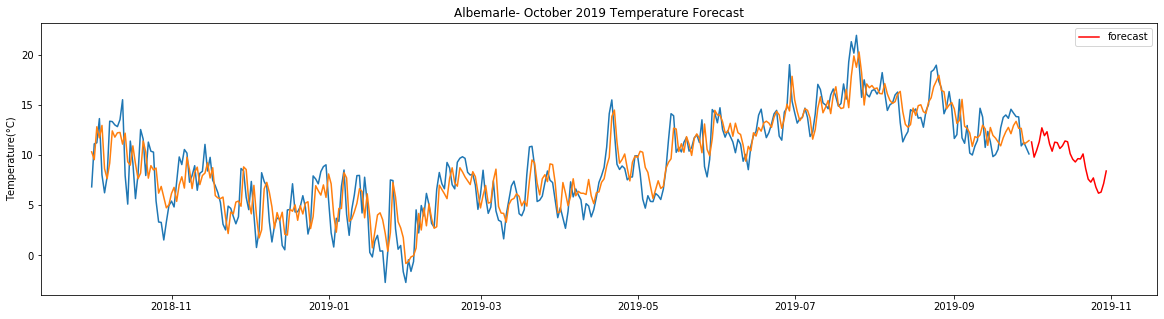

Begwary total row:  3648
split_row:  2918
Training metrics for SVR model
r-square_SVR_Train:  0.89
RMSE_SVR_Train:  0.05
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.84
mse_SVR_test:  0.07
MAE_SVR_test:  0.05
(365, 1)
(1, 365)
(365, 1)


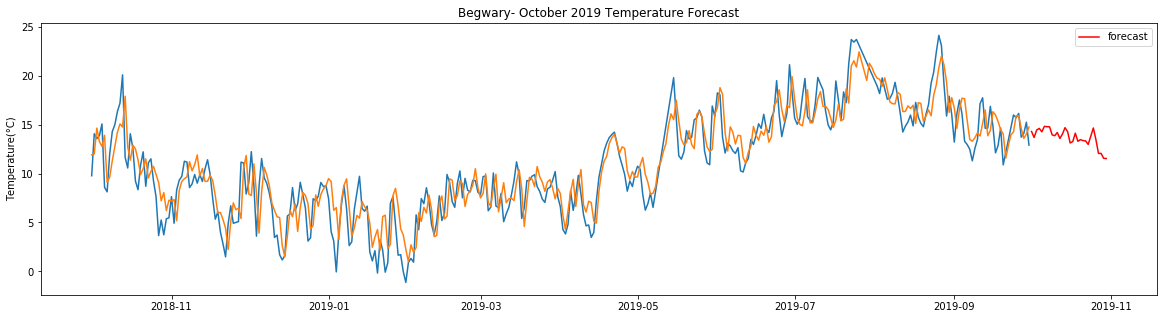

Birmingham_airport total row:  2556
split_row:  2044
Training metrics for SVR model
r-square_SVR_Train:  0.9
RMSE_SVR_Train:  0.05
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.51
mse_SVR_test:  0.08
MAE_SVR_test:  0.06
(147, 1)
(1, 147)
(147, 1)


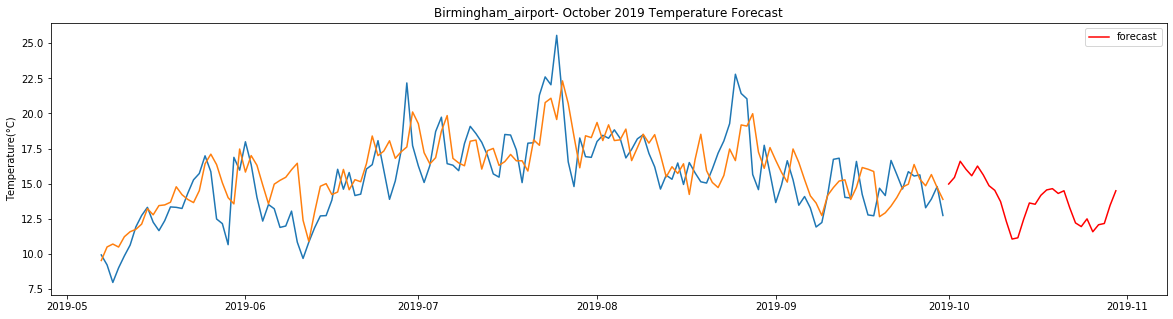

Blackpool_airport total row:  3501
split_row:  2800
Training metrics for SVR model
r-square_SVR_Train:  0.9
RMSE_SVR_Train:  0.04
MAE_SVR_Train:  0.03

Test metrics for SVR model
r-square_SVR_Test:  0.87
mse_SVR_test:  0.07
MAE_SVR_test:  0.05
(336, 1)
(1, 336)
(336, 1)


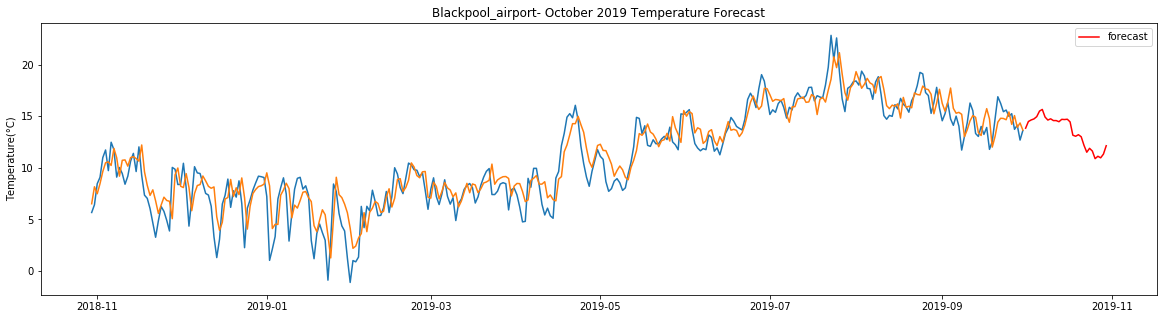

Boulmer_airport total row:  5302
split_row:  4241
Training metrics for SVR model
r-square_SVR_Train:  0.88
RMSE_SVR_Train:  0.06
MAE_SVR_Train:  0.05

Test metrics for SVR model
r-square_SVR_Test:  0.83
mse_SVR_test:  0.08
MAE_SVR_test:  0.06
(696, 1)
(1, 696)
(696, 1)


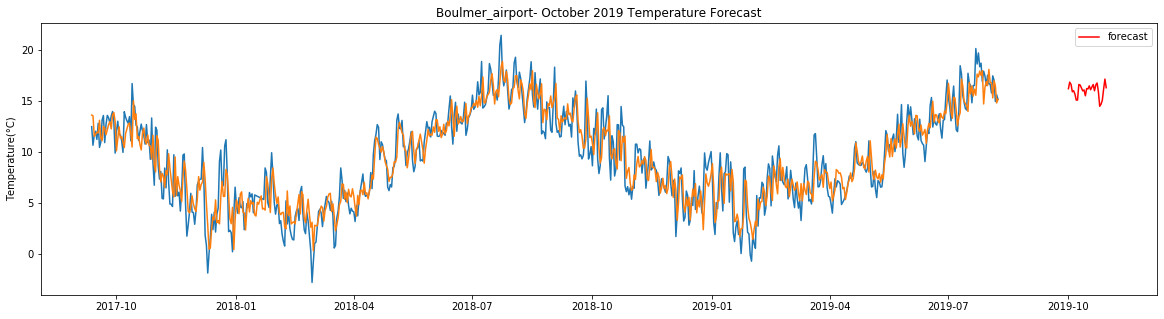

Bournemouth_airport total row:  3648
split_row:  2918
Training metrics for SVR model
r-square_SVR_Train:  0.87
RMSE_SVR_Train:  0.06
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.8
mse_SVR_test:  0.08
MAE_SVR_test:  0.06
(365, 1)
(1, 365)
(365, 1)


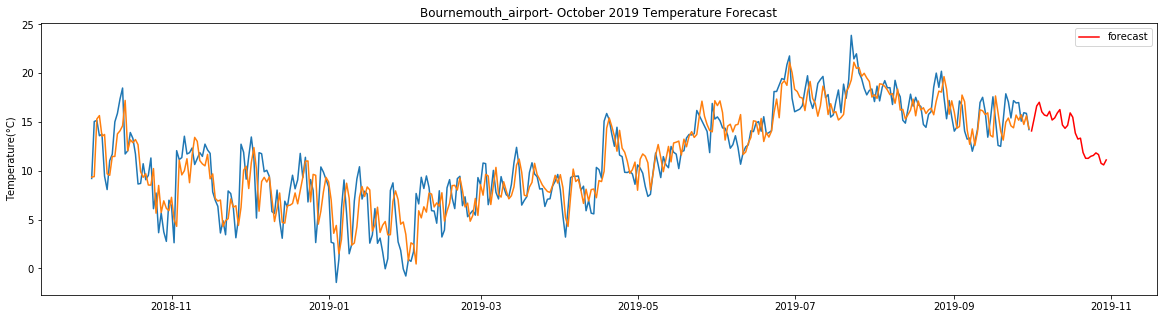

BrizeNorton_airport total row:  5355
split_row:  4284
Training metrics for SVR model
r-square_SVR_Train:  0.89
RMSE_SVR_Train:  0.05
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.87
mse_SVR_test:  0.07
MAE_SVR_test:  0.05
(706, 1)
(1, 706)
(706, 1)


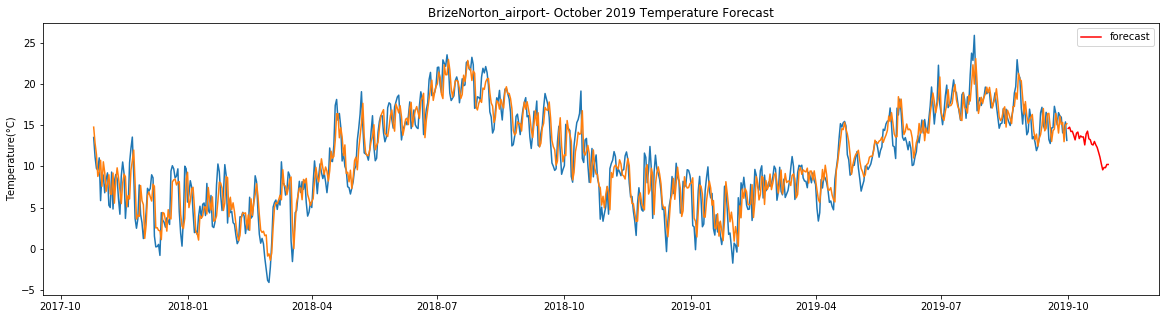

Cardiff_airport total row:  2556
split_row:  2044
Training metrics for SVR model
r-square_SVR_Train:  0.9
RMSE_SVR_Train:  0.05
MAE_SVR_Train:  0.03

Test metrics for SVR model
r-square_SVR_Test:  0.61
mse_SVR_test:  0.07
MAE_SVR_test:  0.05
(147, 1)
(1, 147)
(147, 1)


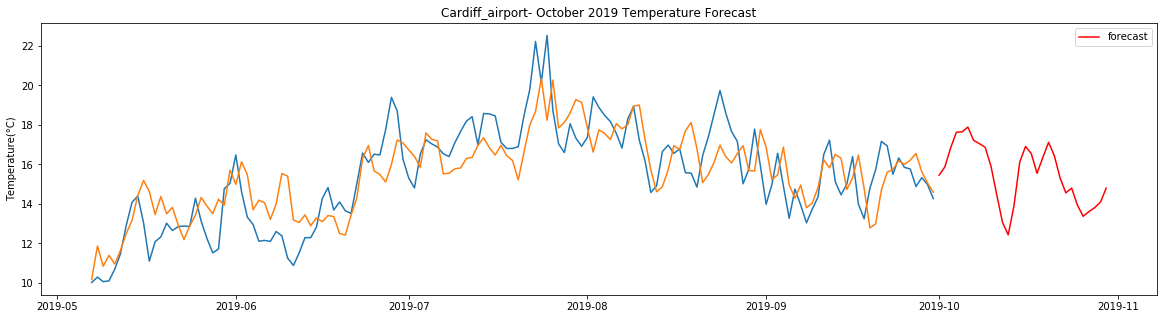

Carlisle total row:  3529
split_row:  2823
Training metrics for SVR model
r-square_SVR_Train:  0.87
RMSE_SVR_Train:  0.05
MAE_SVR_Train:  0.03

Test metrics for SVR model
r-square_SVR_Test:  0.8
mse_SVR_test:  0.08
MAE_SVR_test:  0.06
(341, 1)
(1, 341)
(341, 1)


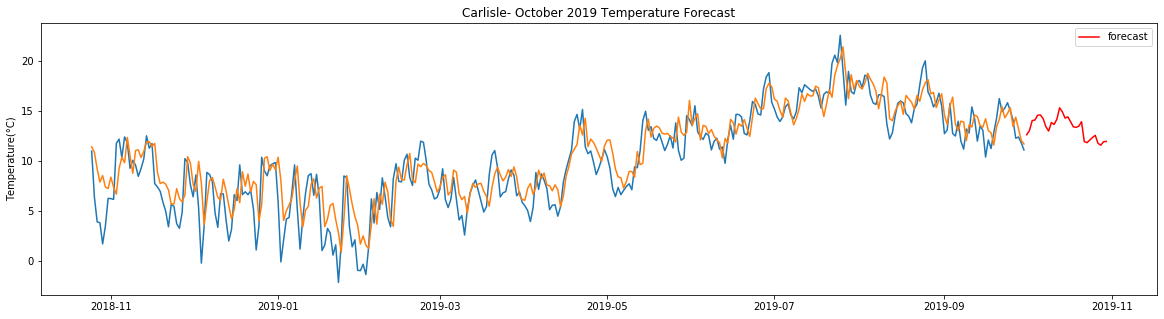

Crosby total row:  3648
split_row:  2918
Training metrics for SVR model
r-square_SVR_Train:  0.91
RMSE_SVR_Train:  0.04
MAE_SVR_Train:  0.03

Test metrics for SVR model
r-square_SVR_Test:  0.85
mse_SVR_test:  0.07
MAE_SVR_test:  0.05
(365, 1)
(1, 365)
(365, 1)


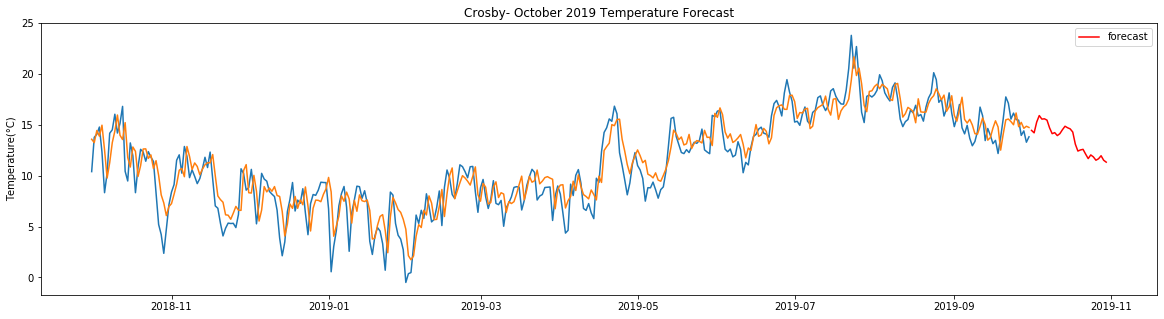

Culdrose_airport total row:  2556
split_row:  2044
Training metrics for SVR model
r-square_SVR_Train:  0.9
RMSE_SVR_Train:  0.05
MAE_SVR_Train:  0.03

Test metrics for SVR model
r-square_SVR_Test:  0.76
mse_SVR_test:  0.06
MAE_SVR_test:  0.04
(147, 1)
(1, 147)
(147, 1)


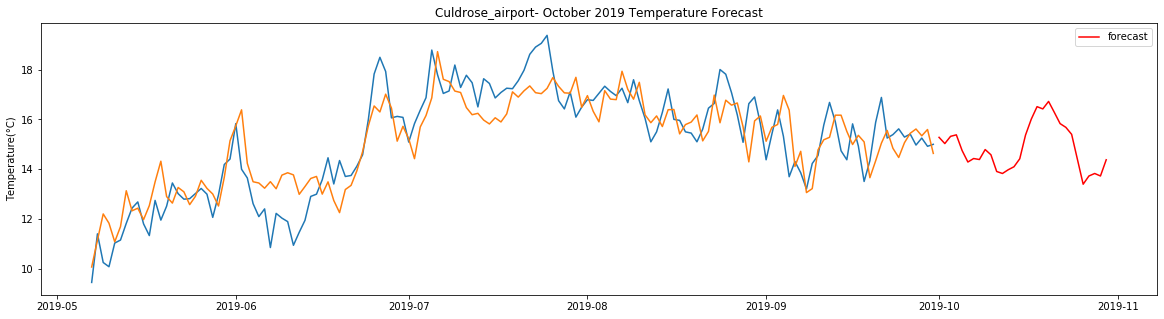

DurhamTeesValley_airport total row:  2556
split_row:  2044
Training metrics for SVR model
r-square_SVR_Train:  0.88
RMSE_SVR_Train:  0.06
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.61
mse_SVR_test:  0.07
MAE_SVR_test:  0.05
(147, 1)
(1, 147)
(147, 1)


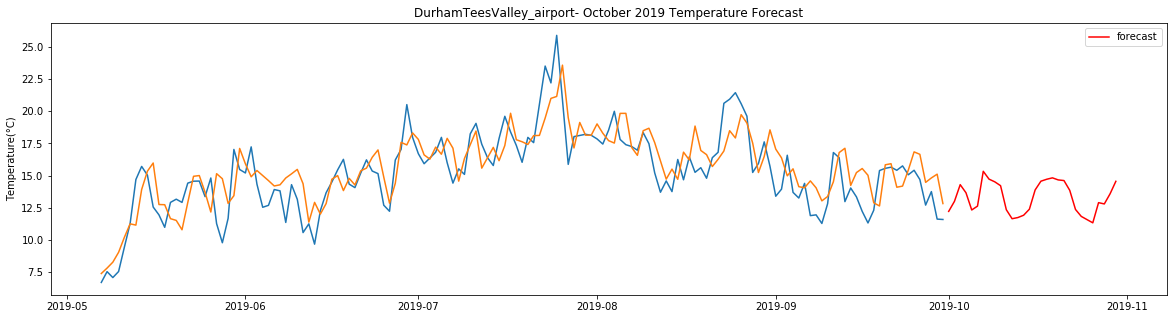

Exeter_airport total row:  2556
split_row:  2044
Training metrics for SVR model
r-square_SVR_Train:  0.88
RMSE_SVR_Train:  0.06
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.5
mse_SVR_test:  0.08
MAE_SVR_test:  0.06
(147, 1)
(1, 147)
(147, 1)


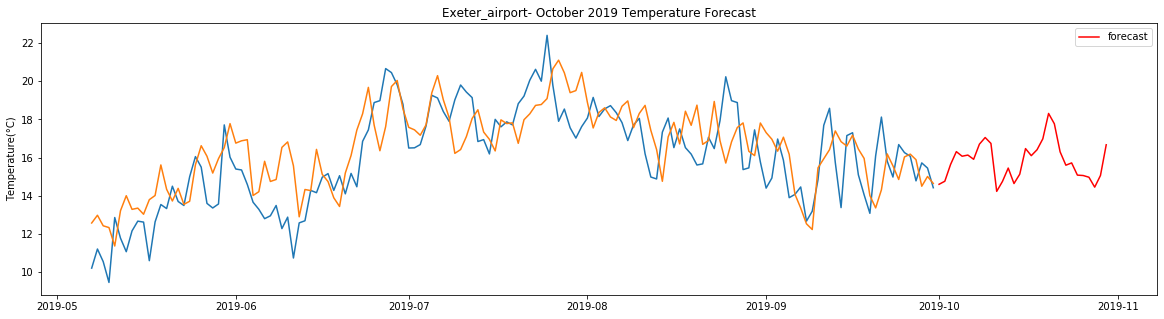

Leconfield_airport total row:  2555
split_row:  2044
Training metrics for SVR model
r-square_SVR_Train:  0.88
RMSE_SVR_Train:  0.06
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.51
mse_SVR_test:  0.09
MAE_SVR_test:  0.07
(146, 1)
(1, 146)
(146, 1)


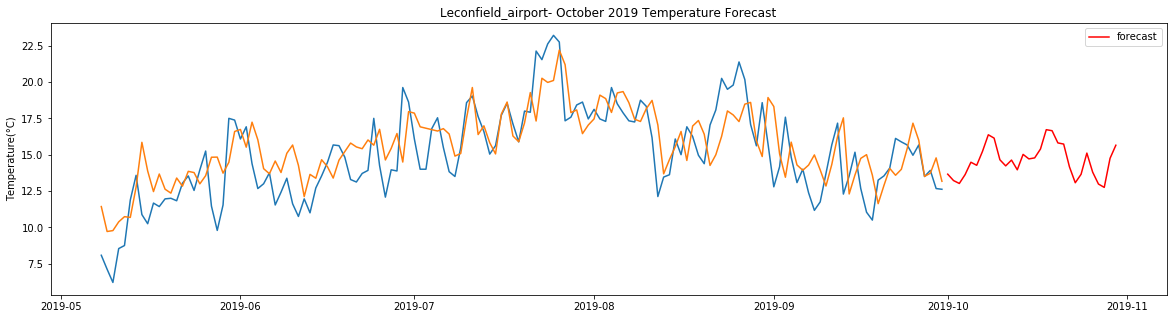

SpadeadamKingwater_airport total row:  2556
split_row:  2044
Training metrics for SVR model
r-square_SVR_Train:  0.87
RMSE_SVR_Train:  0.06
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.62
mse_SVR_test:  0.07
MAE_SVR_test:  0.06
(147, 1)
(1, 147)
(147, 1)


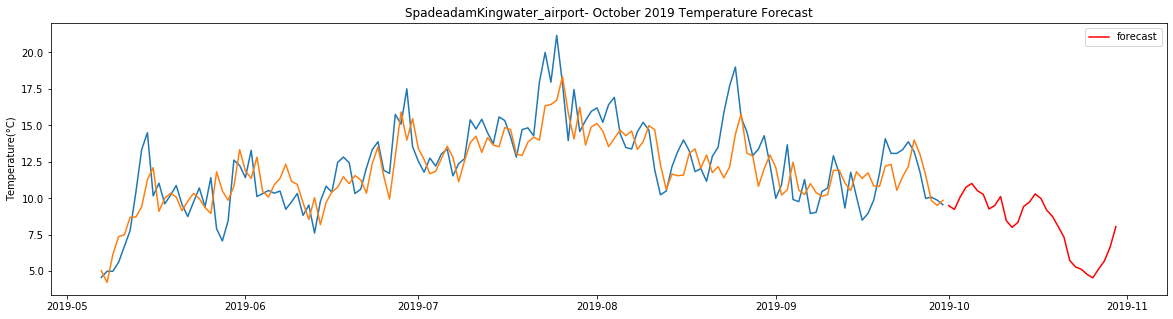

LeedsBradford_airport total row:  2922
split_row:  2337
Training metrics for SVR model
r-square_SVR_Train:  0.89
RMSE_SVR_Train:  0.06
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.79
mse_SVR_test:  0.06
MAE_SVR_test:  0.05
(220, 1)
(1, 220)
(220, 1)


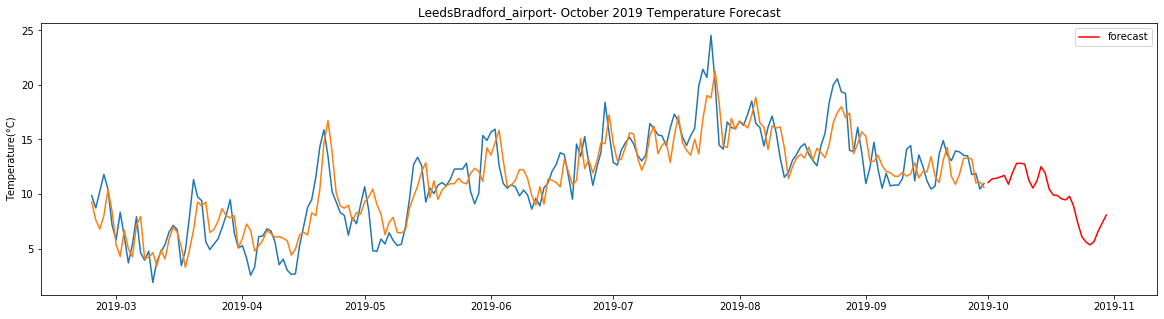

LondonCity_airport total row:  2556
split_row:  2044
Training metrics for SVR model
r-square_SVR_Train:  0.91
RMSE_SVR_Train:  0.05
MAE_SVR_Train:  0.03

Test metrics for SVR model
r-square_SVR_Test:  0.54
mse_SVR_test:  0.08
MAE_SVR_test:  0.06
(147, 1)
(1, 147)
(147, 1)


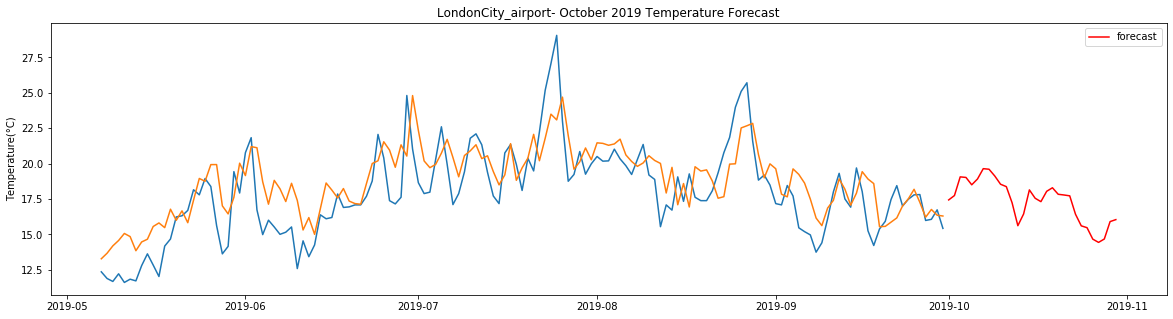

Lyneham_airport total row:  5355
split_row:  4284
Training metrics for SVR model
r-square_SVR_Train:  0.9
RMSE_SVR_Train:  0.05
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.87
mse_SVR_test:  0.07
MAE_SVR_test:  0.05
(706, 1)
(1, 706)
(706, 1)


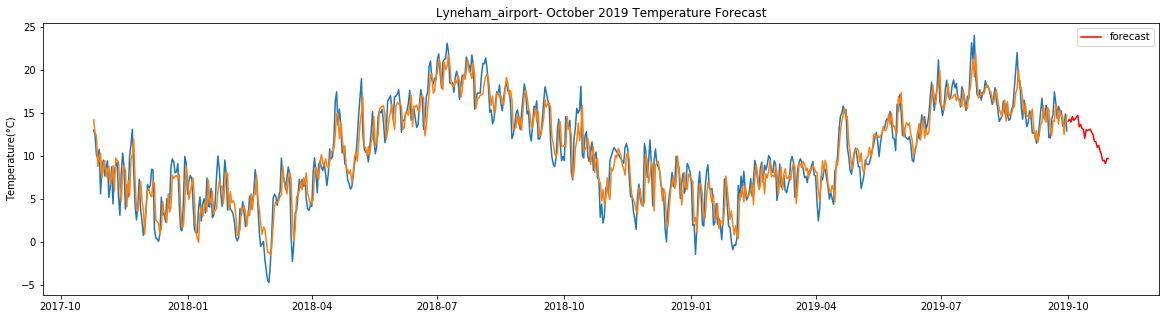

NewquayCornwall_airport total row:  2556
split_row:  2044
Training metrics for SVR model
r-square_SVR_Train:  0.89
RMSE_SVR_Train:  0.05
MAE_SVR_Train:  0.03

Test metrics for SVR model
r-square_SVR_Test:  0.64
mse_SVR_test:  0.07
MAE_SVR_test:  0.05
(147, 1)
(1, 147)
(147, 1)


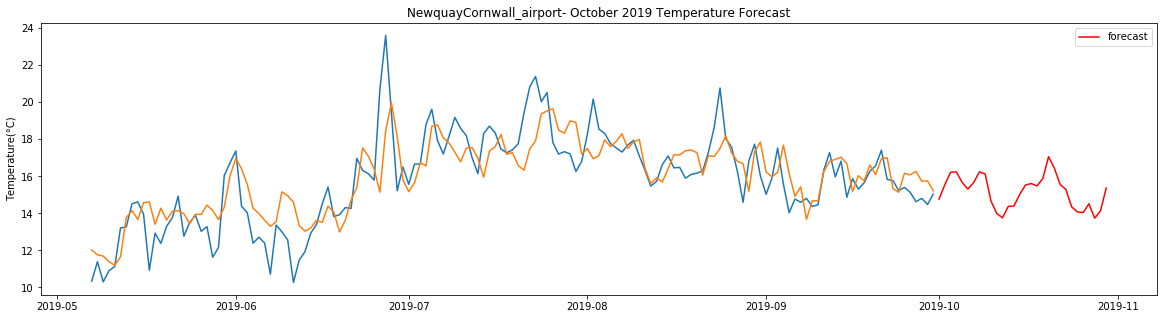

Norwich_airport total row:  2556
split_row:  2044
Training metrics for SVR model
r-square_SVR_Train:  0.89
RMSE_SVR_Train:  0.05
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.54
mse_SVR_test:  0.08
MAE_SVR_test:  0.07
(147, 1)
(1, 147)
(147, 1)


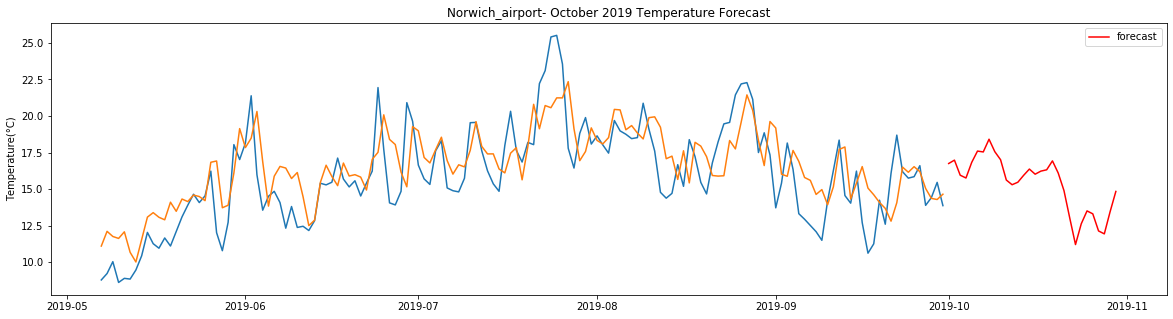

Nottingham total row:  5355
split_row:  4284
Training metrics for SVR model
r-square_SVR_Train:  0.9
RMSE_SVR_Train:  0.05
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.87
mse_SVR_test:  0.06
MAE_SVR_test:  0.05
(706, 1)
(1, 706)
(706, 1)


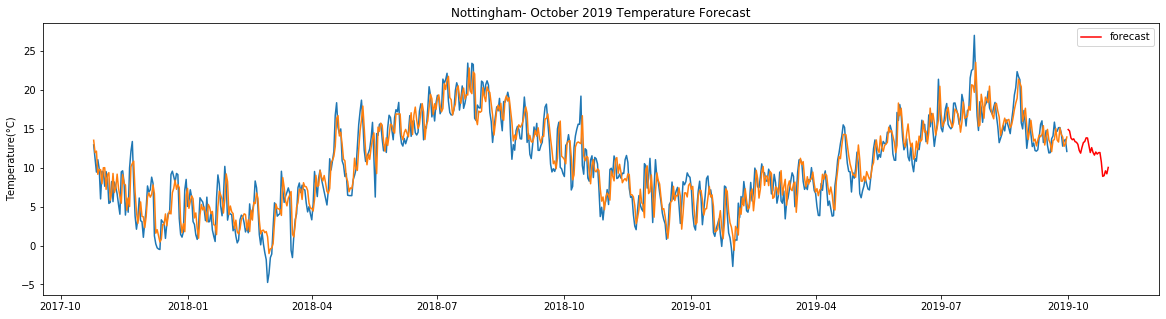

Plymouth_weatherstation total row:  5355
split_row:  4284
Training metrics for SVR model
r-square_SVR_Train:  0.9
RMSE_SVR_Train:  0.05
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.87
mse_SVR_test:  0.06
MAE_SVR_test:  0.05
(706, 1)
(1, 706)
(706, 1)


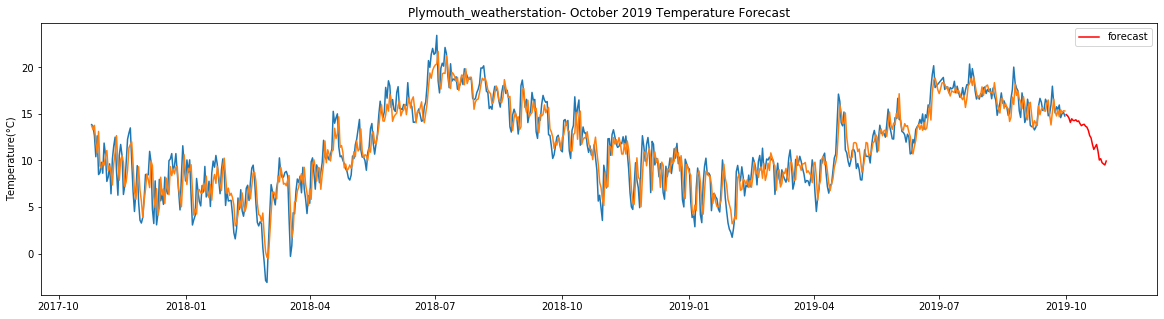

Rostherne total row:  2495
split_row:  1996
Training metrics for SVR model
r-square_SVR_Train:  0.88
RMSE_SVR_Train:  0.06
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.5
mse_SVR_test:  0.08
MAE_SVR_test:  0.06
(134, 1)
(1, 134)
(134, 1)


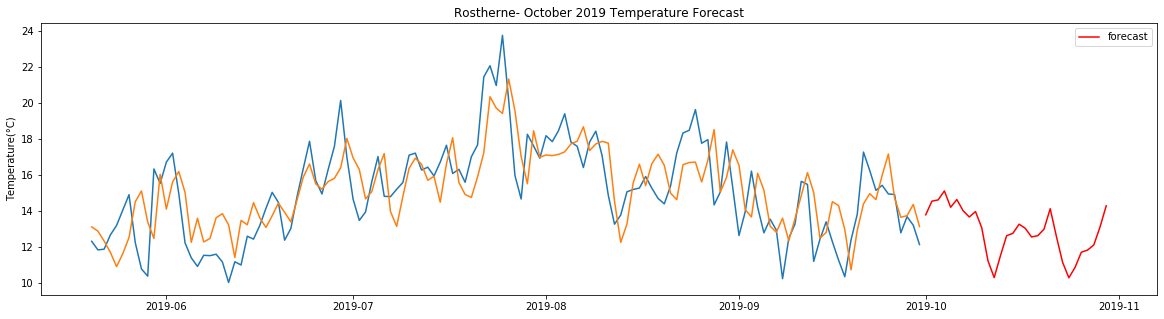

Scampton_airport total row:  3543
split_row:  2834
Training metrics for SVR model
r-square_SVR_Train:  0.88
RMSE_SVR_Train:  0.05
MAE_SVR_Train:  0.03

Test metrics for SVR model
r-square_SVR_Test:  0.79
mse_SVR_test:  0.08
MAE_SVR_test:  0.06
(344, 1)
(1, 344)
(344, 1)


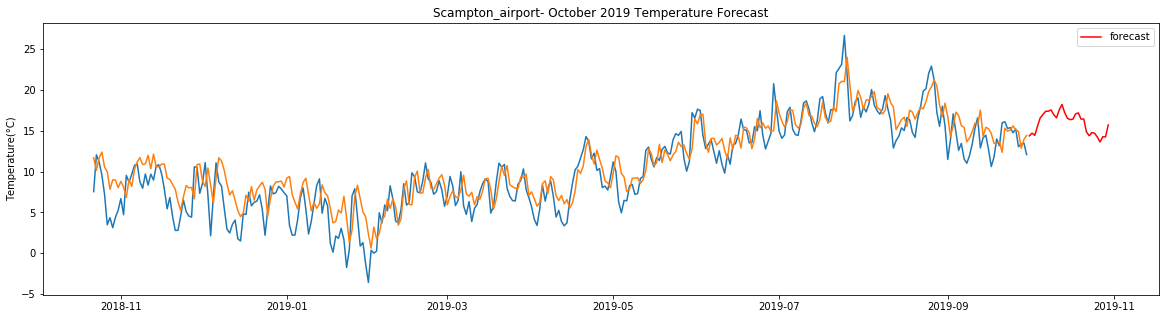

Shawbury_airport total row:  5355
split_row:  4284
Training metrics for SVR model
r-square_SVR_Train:  0.87
RMSE_SVR_Train:  0.05
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.84
mse_SVR_test:  0.07
MAE_SVR_test:  0.06
(706, 1)
(1, 706)
(706, 1)


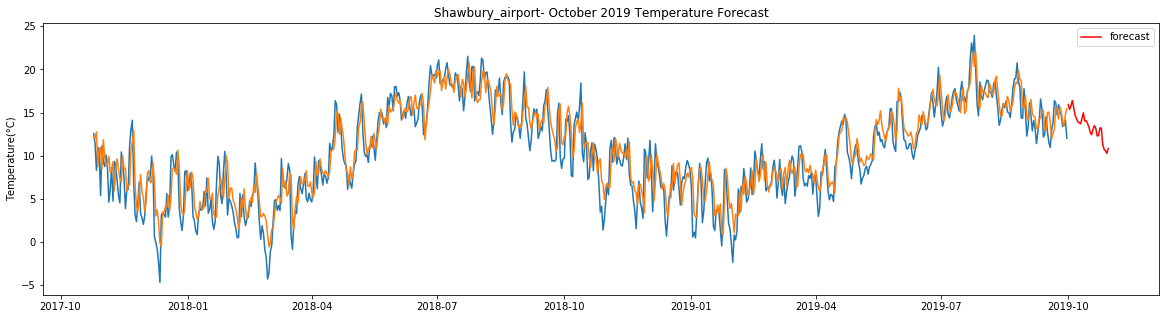

Southend_on_Sea_AWS total row:  3648
split_row:  2918
Training metrics for SVR model
r-square_SVR_Train:  0.91
RMSE_SVR_Train:  0.06
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.86
mse_SVR_test:  0.07
MAE_SVR_test:  0.05
(365, 1)
(1, 365)
(365, 1)


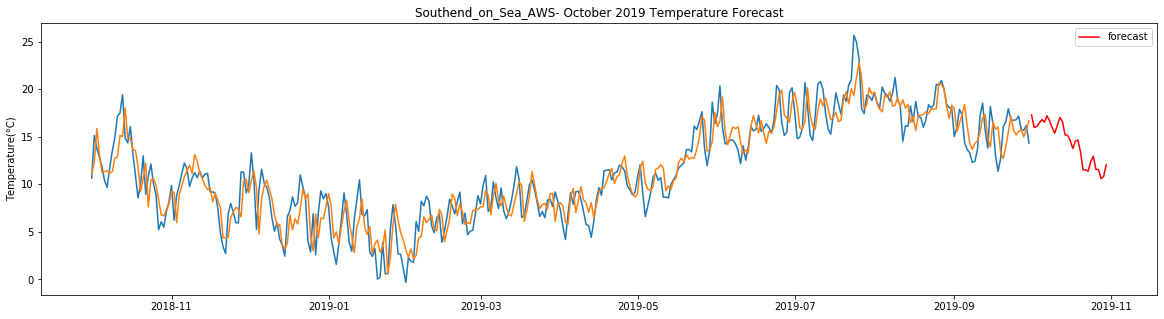

Stansted_airport total row:  2556
split_row:  2044
Training metrics for SVR model
r-square_SVR_Train:  0.9
RMSE_SVR_Train:  0.05
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.53
mse_SVR_test:  0.08
MAE_SVR_test:  0.07
(147, 1)
(1, 147)
(147, 1)


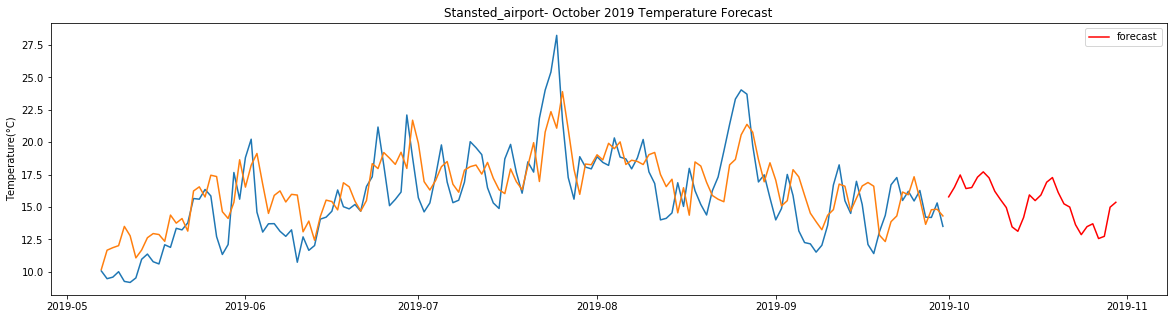

Wittering_airport total row:  5355
split_row:  4284
Training metrics for SVR model
r-square_SVR_Train:  0.89
RMSE_SVR_Train:  0.05
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.87
mse_SVR_test:  0.06
MAE_SVR_test:  0.05
(706, 1)
(1, 706)
(706, 1)


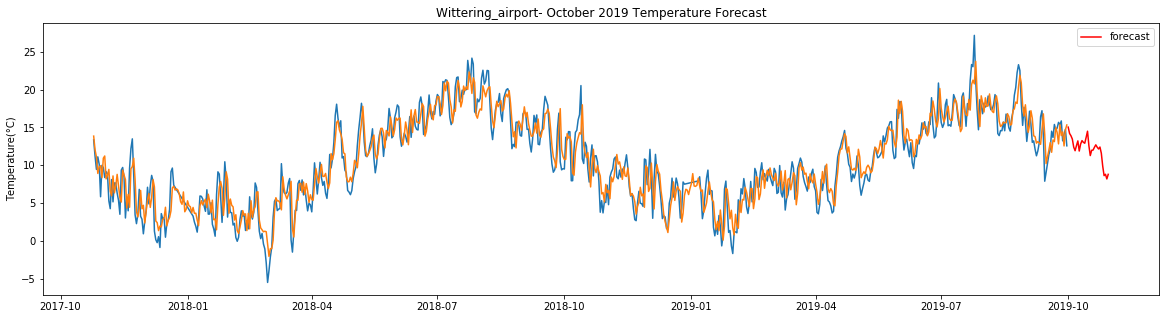

Yeovilton_airport total row:  5355
split_row:  4284
Training metrics for SVR model
r-square_SVR_Train:  0.87
RMSE_SVR_Train:  0.05
MAE_SVR_Train:  0.04

Test metrics for SVR model
r-square_SVR_Test:  0.84
mse_SVR_test:  0.08
MAE_SVR_test:  0.06
(706, 1)
(1, 706)
(706, 1)


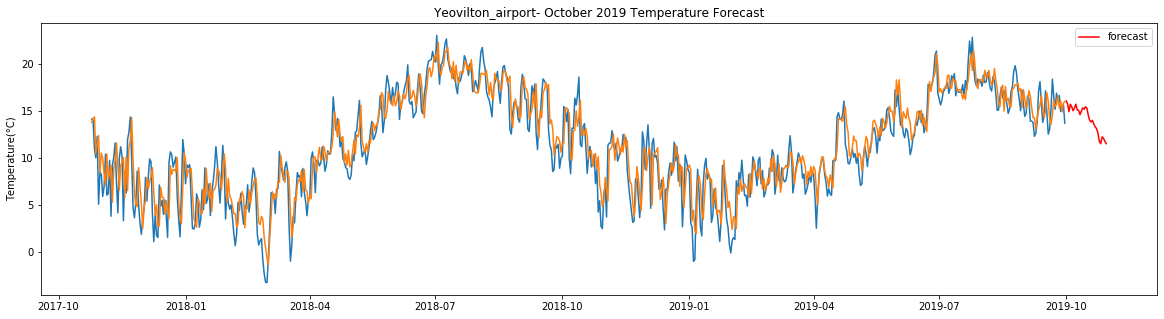

Wall time: 5min 14s


In [24]:
%%time
# Fitting and forecast using SVM
svr_prediction = england_temp_svr(all_station_temp, 365, 30)

In the above section the SVR model is trained on past time series data followed by forecasting temperature for the month of October,2019 for each of the stations. The results are plotted for each station with past observed temperatures in Blue, validation in Orange and forecast in Red. The validation closely matches the observed daily temperatures in most of the cases as also given by the test metrics of r-square with the highest values reaching upto 0.87 for the SVR model.    

## Temperature forecasted by SVR model <a class="anchor" id="14"></a>
The output obtained by the above SVR model is visualized here which will now be processed to interpolate temperature for the whole of England. 

In [25]:
# Daily forecast obtained from the SVR model for each of the weather stations
svr_prediction.head()

Albemarle  Begwary  Birmingham_airport  Blackpool_airport  \
2019-10-01      11.29    14.30               14.97              13.83   
2019-10-02       9.78    13.69               15.44              14.48   
2019-10-03      10.47    14.45               16.59              14.63   
2019-10-04      11.32    14.62               16.02              14.73   
2019-10-05      12.70    14.27               15.56              14.95   

            Boulmer_airport  Bournemouth_airport  BrizeNorton_airport  \
2019-10-01            16.18                14.08                14.59   
2019-10-02            16.82                15.33                14.74   
2019-10-03            16.61                16.64                14.21   
2019-10-04            15.88                17.02                14.25   
2019-10-05            15.98                16.04                13.76   

            Cardiff_airport  Carlisle  Crosby  ...  Norwich_airport  \
2019-10-01            15.45     12.60   14.45  ...            16.75   
2019-10-02            15.87     13.01   14.21  ...            16.98   
2019-10-03            16.83     14.01   15.27  ...            15.95   
2019-10-04            17.63     14.07   15.91  ...            15.76   
2019-10-05            17.65     14.55   15.56  ...            16.83   

            Nottingham  Plymouth_weatherstation  Rostherne  Scampton_airport  \
2019-10-01       14.93                    14.93      13.77             14.37   
2019-10-02       14.74                    14.80      14.53             14.70   
2019-10-03       13.84                    14.56      14.60             14.43   
2019-10-04       13.62                    14.09      15.10             15.55   
2019-10-05       13.73                    14.48      14.19             16.57   

            Shawbury_airport  Southend_on_Sea_AWS  Stansted_airport  \
2019-10-01             15.94                17.29             15.78   
2019-10-02             15.38                15.99             16.52   
2019-10-03             15.76                16.06             17.47   
2019-10-04             16.40                16.43             16.42   
2019-10-05             15.57                16.80             16.50   

            Wittering_airport  Yeovilton_airport  
2019-10-01              15.03              16.06  
2019-10-02              14.19              15.77  
2019-10-03              13.89              14.92  
2019-10-04              13.45              15.71  
2019-10-05              12.39              15.46  

[5 rows x 29 columns]

In [26]:
# Change staion names to index
england_temp_forecast = svr_prediction.transpose()
england_temp_forecast.head()

2019-10-01  2019-10-02  2019-10-03  2019-10-04  \
Albemarle                11.29        9.78       10.47       11.32   
Begwary                  14.30       13.69       14.45       14.62   
Birmingham_airport       14.97       15.44       16.59       16.02   
Blackpool_airport        13.83       14.48       14.63       14.73   
Boulmer_airport          16.18       16.82       16.61       15.88   

                    2019-10-05  2019-10-06  2019-10-07  2019-10-08  \
Albemarle                12.70       11.92       12.31       11.09   
Begwary                  14.27       14.83       14.79       14.78   
Birmingham_airport       15.56       16.25       15.62       14.85   
Blackpool_airport        14.95       15.49       15.65       14.91   
Boulmer_airport          15.98       15.66       15.07       15.07   

                    2019-10-09  2019-10-10  ...  2019-10-21  2019-10-22  \
Albemarle                10.37       11.27  ...       10.10        8.66   
Begwary                  13.96       13.87  ...       13.37       13.34   
Birmingham_airport       14.52       13.72  ...       14.49       13.28   
Blackpool_airport        14.62       14.74  ...       13.00       12.17   
Boulmer_airport          16.59       16.54  ...       15.98       16.55   

                    2019-10-23  2019-10-24  2019-10-25  2019-10-26  \
Albemarle                 7.59        7.29        7.71        6.78   
Begwary                  12.98       13.82       14.66       13.47   
Birmingham_airport       12.20       11.94       12.49       11.57   
Blackpool_airport        11.50       11.88       11.62       10.88   
Boulmer_airport          16.74       15.89       14.46       14.66   

                    2019-10-27  2019-10-28  2019-10-29  2019-10-30  
Albemarle                 6.19        6.30        7.15        8.40  
Begwary                  12.06       12.06       11.56       11.54  
Birmingham_airport       12.07       12.16       13.45       14.49  
Blackpool_airport        11.11       10.96       11.32       12.13  
Boulmer_airport          15.04       16.14       17.12       16.28  

[5 rows x 30 columns]

In [27]:
# Make station names to a column
england_temp_forecast_station = england_temp_forecast.reset_index()
england_temp_forecast_station = england_temp_forecast_station.rename(columns={'index':'Station'})
england_temp_forecast_station.head()

Station  2019-10-01 00:00:00  2019-10-02 00:00:00  \
0           Albemarle                11.29                 9.78   
1             Begwary                14.30                13.69   
2  Birmingham_airport                14.97                15.44   
3   Blackpool_airport                13.83                14.48   
4     Boulmer_airport                16.18                16.82   

   2019-10-03 00:00:00  2019-10-04 00:00:00  2019-10-05 00:00:00  \
0                10.47                11.32                12.70   
1                14.45                14.62                14.27   
2                16.59                16.02                15.56   
3                14.63                14.73                14.95   
4                16.61                15.88                15.98   

   2019-10-06 00:00:00  2019-10-07 00:00:00  2019-10-08 00:00:00  \
0                11.92                12.31                11.09   
1                14.83                14.79                14.78   
2                16.25                15.62                14.85   
3                15.49                15.65                14.91   
4                15.66                15.07                15.07   

   2019-10-09 00:00:00  ...  2019-10-21 00:00:00  2019-10-22 00:00:00  \
0                10.37  ...                10.10                 8.66   
1                13.96  ...                13.37                13.34   
2                14.52  ...                14.49                13.28   
3                14.62  ...                13.00                12.17   
4                16.59  ...                15.98                16.55   

   2019-10-23 00:00:00  2019-10-24 00:00:00  2019-10-25 00:00:00  \
0                 7.59                 7.29                 7.71   
1                12.98                13.82                14.66   
2                12.20                11.94                12.49   
3                11.50                11.88                11.62   
4                16.74                15.89                14.46   

   2019-10-26 00:00:00  2019-10-27 00:00:00  2019-10-28 00:00:00  \
0                 6.78                 6.19                 6.30   
1                13.47                12.06                12.06   
2                11.57                12.07                12.16   
3                10.88                11.11                10.96   
4                14.66                15.04                16.14   

   2019-10-29 00:00:00  2019-10-30 00:00:00  
0                 7.15                 8.40  
1                11.56                11.54  
2                13.45                14.49  
3                11.32                12.13  
4                17.12                16.28  

[5 rows x 31 columns]

In [28]:
# Join forecast temperature data to weather stations using the Staion column
predicted_temp_by_station = pd.merge(england_temp_forecast_station, england_weather_stations_layer_sdf, left_on='Station', right_on='Station', how='left')
predicted_temp_by_station.head()

Station  2019-10-01 00:00:00  2019-10-02 00:00:00  \
0           Albemarle                11.29                 9.78   
1             Begwary                14.30                13.69   
2  Birmingham_airport                14.97                15.44   
3   Blackpool_airport                13.83                14.48   
4     Boulmer_airport                16.18                16.82   

   2019-10-03 00:00:00  2019-10-04 00:00:00  2019-10-05 00:00:00  \
0                10.47                11.32                12.70   
1                14.45                14.62                14.27   
2                16.59                16.02                15.56   
3                14.63                14.73                14.95   
4                16.61                15.88                15.98   

   2019-10-06 00:00:00  2019-10-07 00:00:00  2019-10-08 00:00:00  \
0                11.92                12.31                11.09   
1                14.83                14.79                14.78   
2                16.25                15.62                14.85   
3                15.49                15.65                14.91   
4                15.66                15.07                15.07   

   2019-10-09 00:00:00  ...  2019-10-25 00:00:00  2019-10-26 00:00:00  \
0                10.37  ...                 7.71                 6.78   
1                13.96  ...                14.66                13.47   
2                14.52  ...                12.49                11.57   
3                14.62  ...                11.62                10.88   
4                16.59  ...                14.46                14.66   

   2019-10-27 00:00:00  2019-10-28 00:00:00  2019-10-29 00:00:00  \
0                 6.19                 6.30                 7.15   
1                12.06                12.06                11.56   
2                12.07                12.16                13.45   
3                11.11                10.96                11.32   
4                15.04                16.14                17.12   

   2019-10-30 00:00:00  FID          Y         X  \
0                 8.40    1  55.016667 -1.866667   
1                11.54    2  52.216667 -0.483333   
2                14.49    3  52.450000 -1.733333   
3                12.13    4  53.766667 -3.033333   
4                16.28    5  55.420300 -1.599700   

                                               SHAPE  
0  {'x': -207796.38285121127, 'y': 7365101.445978...  
1  {'x': -53804.420512971476, 'y': 6839396.777444...  
2  {'x': -192953.78400456344, 'y': 6881903.804921...  
3  {'x': -337669.1220358203, 'y': 7126089.0211904...  
4  {'x': -178077.78942199165, 'y': 7443868.808735...  

[5 rows x 35 columns]

## Result Visualization <a class="anchor" id="15"></a>

The table above gives the daily temperature forecast for the month of October,2019 for all the 29 weather stations in England, which were obtained using the SVR algorithm. Out of these predictions the first day of October is selected for creating a probable temperature surface for the entire country.

In [29]:
# Select the first day out 
oct1st_temp = predicted_temp_by_station.iloc[:, [0,1,33,32]]
oct1st_temp = oct1st_temp.rename(columns={oct1st_temp.columns[1]:'temp_pred'})
oct1st_temp.head()

Station  temp_pred         X          Y
0           Albemarle      11.29 -1.866667  55.016667
1             Begwary      14.30 -0.483333  52.216667
2  Birmingham_airport      14.97 -1.733333  52.450000
3   Blackpool_airport      13.83 -3.033333  53.766667
4     Boulmer_airport      16.18 -1.599700  55.420300

In [30]:
# convert dataframe to a spatial dataframe
sdf = oct1st_temp.spatial.from_xy(df=oct1st_temp, sr=4326, x_column='X', y_column='Y')
sdf.head()

C:\Users\sup10432\.conda\envs\arcgis171\lib\site-packages\IPython\lib\pretty.py:402: FutureWarning: 'ExtensionArray._formatting_values' is deprecated. Specify 'ExtensionArray._formatter' instead.
  return _repr_pprint(obj, self, cycle)
C:\Users\sup10432\.conda\envs\arcgis171\lib\site-packages\pandas\io\formats\html.py:606: FutureWarning: 'ExtensionArray._formatting_values' is deprecated. Specify 'ExtensionArray._formatter' instead.
  super().render()


Station  temp_pred         X          Y  \
0           Albemarle      11.29 -1.866667  55.016667   
1             Begwary      14.30 -0.483333  52.216667   
2  Birmingham_airport      14.97 -1.733333  52.450000   
3   Blackpool_airport      13.83 -3.033333  53.766667   
4     Boulmer_airport      16.18 -1.599700  55.420300   

                                               SHAPE  
0  {"x": -1.866666667, "y": 55.01666667, "spatial...  
1  {"x": -0.483333333, "y": 52.21666667, "spatial...  
2  {"x": -1.733333333, "y": 52.45, "spatialRefere...  
3  {"x": -3.033333333, "y": 53.76666667, "spatial...  
4  {"x": -1.5997, "y": 55.4203, "spatialReference...

In [31]:
# create feature layer from the spatial dataframe
oct1st_temp_points = gis.content.import_data(sdf, title='eng_temp_points')

In [32]:
oct1st_temp_points

<Item title:"eng_temp_points" type:Feature Layer Collection owner:arcgis_python>

Spatial Interpolation -  The arcgis api python tool of "interpolate_points" is used to interpolate temperature for England. The inputs for the tool are:

i) feature layer having the predicted temperature for all the weather stations

ii) interpolate_options spcecify the speed v/s accuracy on a range of 1 to 9 with 9 as the maximum accuracy

iii) field indicates the column name in the feaure layer which has the predicted temperautres

iv) bounding_polygon_layer here is the England boundary shapefile which sets the boundary within which the spatial interpolation would be estimated

v) finally the name of the resulting output interpoalted surface.  

more detail is available here  [interpolate tool](https://developers.arcgis.com/rest/analysis/api-reference/interpolate-points.htm)

In [33]:
# Interpolate the predicted temperature data to create forecast surface for England
oct1st_temp_surface = interpolate_points(oct1st_temp_points, 
                                         interpolate_option=9,                                         
                                         field='temp_pred', 
                                         bounding_polygon_layer=england_boundary_layer,
                                         output_name='Interpolated Temperature'+ str(datetime.now().microsecond))

In [34]:
oct1st_temp_surface

<Item title:"Interpolated Temperature784886" type:Feature Layer Collection owner:arcgis_python>


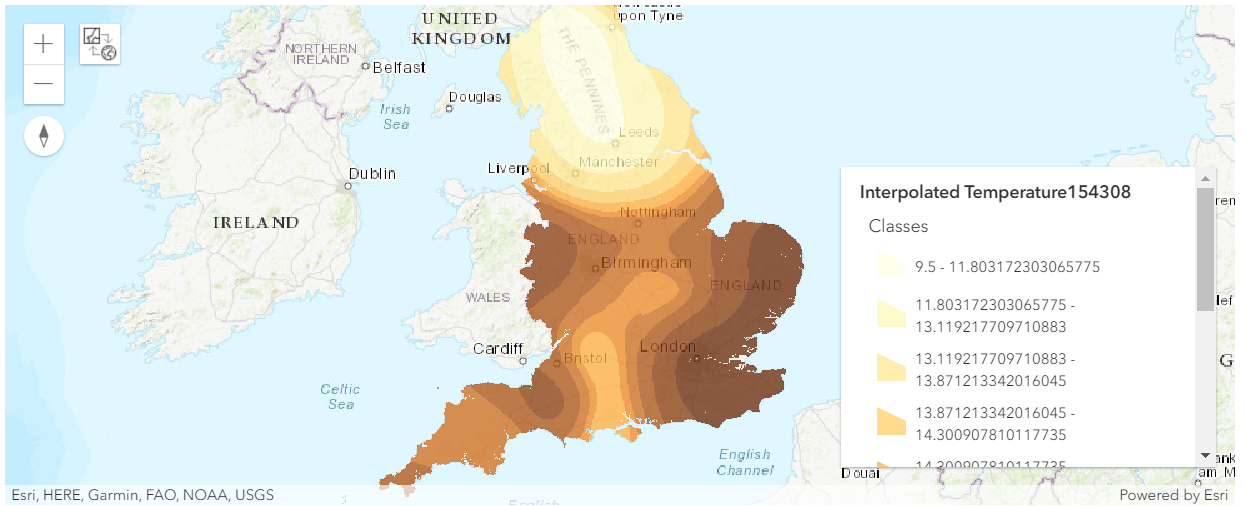

In [5]:
# Plot the interpolated temperature surface
m1 = gis.map('England', zoomlevel=6)
m1.add_layer(oct1st_temp_surface)
m1.legend = True
m1

The interpolated forecast temperature surface above for England shows that temperature gradually increases from the northern to the southern part of the country, and ranges from a minimum of 9.5 degrees to a maximum of 17.43 degree Celsius respectively, with two distinct zones dividing the country. Also lower temperatures are prevalent in the interior part of the country compared to the coastal belt regions, with London falling in the maximum temperature zone. This is expected since coastal regions are usually warmer than inland areas due to a different climatic conditions.  

## Conclusion<a class="anchor" id="16"></a>

In this notebook a timeseries temperature dataset was used to predict daily temperature for England for the month of October using historic data from 29 weather stations. Two methods were used for the study — first a deep learning framework of LSTM was used followed by a machine learning method of Support Vector Regression. Both the models were able to model the data relatively well as evident from the high accuracy obtained for both train and test set. However the SVM model was consistently performing better than the LSTM model with higher accuracy. Some instances of low accuracy for both the models were caused for certain stations due to less number of training data points available. 

Similarly interesting differences was observed while forecasting daily temperatures using the two models. Here the SVR model was able to capture the daily fluctuations in greater detail which looked more real compared to the forecast returned by the LSTM model, as observed from the forecast plots. Besides, the total run time for the SVR model for fitting the data was only  a few minutes and was far less than the time taken by the LSTM model, which was training for 100 epcohs for each station. 

Finally the sample shows how deep learning and machine learning models could be combined with spatial tools in ArcGIS to process timeseries data and produce meaningful results that could be valuable for various industry verticals. 

### Summary of methods used <a class="anchor" id="17"></a>

| Method | Question | Examples |
| -| - |-|
| interpolate_points| What is the value of any points located between other given points?  |Predicting temperature at any intermediate location based on measurement from surrounding station |


### Data resources <a class="anchor" id="18"></a>

| Shapefile | Source | Link |
| -| - |-|
| england_border| Counties and Unitary Authorities (December 2016) Full Clipped Boundaries in England and Wales  |https://data.gov.uk|
| england_weather_stations| Weather for 243 countries of the world  |https://rp5.ru/Weather_in_the_world|
| table(england historic weather data)| Weather for 243 countries of the world  |https://rp5.ru/Weather_in_the_world|   
